In [5]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

note_id  person_id  age gender_source_value        BMI  \
0        101058         29   81                   F  25.247087   
1         57801         64   60                   F  24.376249   
2         71288         64   60                   F  24.376249   
3        135104         64   60                   F  24.376249   
4        221210         71   94                   M  27.963140   
...         ...        ...  ...                 ...        ...   
161214   297111    4055249    1                   M  23.700428   
161215   297455    4055328    1                   M  20.612160   
161216   297761    4055407    1                   M  12.502703   
161217   297753    4055558    4                   F  14.365794   
161218   298112    4055685    1                   M  18.382103   

       admission_department   division   ward  asa_class  surgeon_id  ...  \
0           General Surgery  Admission  NUGW2          2        9885  ...   
1            Otolaryngology  Admission    102          2        6194  ...   
2            Otolaryngology  Admission    102          3        6194  ...   
3            Otolaryngology  Admission    102          3        6194  ...   
4               Orthopedics  Admission     41          2       29473  ...   
...                     ...        ...    ...        ...         ...  ...   
161214    Pediatric Surgery  Admission     5A          1      100613  ...   
161215    Pediatric Urology        Day   PDSC          1        6259  ...   
161216    Pediatric Surgery  Admission     5A          2      105057  ...   
161217    Pediatric Surgery  Admission     5A          2      105057  ...   
161218    Pediatric Surgery  Admission     5A          1      105057  ...   

       condition_source_value surgery_room previous_surgery emergency_status  \
0                   D00002196          203                N                N   
1                   D00003798          504                N                N   
2                   D00003798          504                Y                N   
3                   D00003798          504                Y                N   
4                   D00018711          108                N                N   
...                       ...          ...              ...              ...   
161214              D00011688            5                N                Y   
161215              D00016707            7                N                N   
161216              D00011524            5                N                N   
161217              D00004831            5                N                N   
161218              D00011589            5                N                N   

       op_timing day_of_the_week week_of_the_month      month  \
0            TF2        Thursday                 4    October   
1             8A          Friday                 2    January   
2            TF4          Monday                 4      April   
3            TF2          Monday                 3     August   
4            TF4          Monday                 5      March   
...          ...             ...               ...        ...   
161214       etc         Tuesday                 2  September   
161215        8A          Monday                 4  September   
161216        8A       Wednesday                 3  September   
161217       TF6       Wednesday                 3  September   
161218        8A          Friday                 4  September   

       surgeon_estimated_op_time surgery_duration  
0                            130               66  
1                            300              130  
2                            100               85  
3                            100               83  
4                            100               63  
...                          ...              ...  
161214                       200              123  
161215                       130               45  
161216                       130               43  
161217                      

In [6]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note_id', 'person_id', 'surgeon_estimated_op_time', 'final_op_name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition_source_value', 'op_code', 'surgeon_id', 'ward', 'admission_department', 'surgery_room']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical_department', 'op_timing', 'month', 'anesthesia_type', 
                'day_of_the_week', 'asa_class', 'week_of_the_month', 
                'division', 'previous_surgery', 'emergency_status', 'gender_source_value']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery_duration", axis=1)
y_all = df_encoded["surgery_duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery_duration, Length: 128975, dtype: int64

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 분과별 데이터셋 준비
departments = df['surgical_department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련 (랜덤 포레스트 예시)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae = mean_absolute_error(y_test_all, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2 = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae}, RMSE: {rmse}, R²: {r2}")

Ensemble MAE: 16.67870301451433, RMSE: 31.662393537060968, R²: 0.9158268414503081


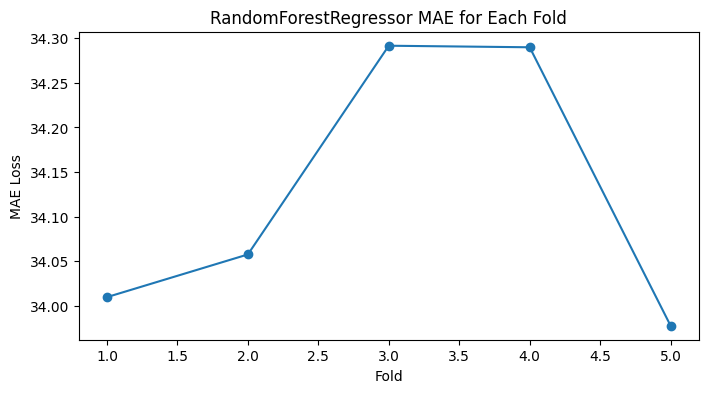

34.12521776250484

In [9]:
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

# Setting up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for MAE of each fold
mae_scores = []

# Performing cross-validation
for train_index, test_index in kf.split(X_all):
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

    # Training the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions and calculating MAE
    predictions = model.predict(X_test)
    fold_mae = mean_absolute_error(y_test, predictions)
    mae_scores.append(fold_mae)

# Plotting the MAE for each fold
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, len(mae_scores) + 1), mae_scores, marker='o')
ax.set_xlabel('Fold')
ax.set_ylabel('MAE Loss')
ax.set_title('RandomForestRegressor MAE for Each Fold')
plt.show()

# Average MAE across folds
average_mae = np.mean(mae_scores)
average_mae


In [10]:
from sklearn.model_selection import cross_val_score

# Setting up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for cross-validation results
cv_results = {}

# Performing cross-validation for each department
for dept in departments:
    dept_col_name = 'surgical_department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # Training RandomForestRegressor model with cross-validation
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Calculating MAE for each fold
    mae_scores = -cross_val_score(model, X_dept, y_dept, cv=kf, scoring='neg_mean_absolute_error')
    
    # Storing the results
    cv_results[dept] = mae_scores

# Displaying the cross-validation MAE results for each department
cv_results


{'General Surgery': array([36.1838703 , 36.59642248, 36.39320001, 36.63163307, 36.39221169]),
 'Otolaryngology': array([45.62419958, 42.51285775, 44.67912489, 45.29652931, 44.92204333]),
 'Orthopedics': array([35.18120337, 33.88641697, 34.08216672, 34.72752934, 33.93806801]),
 'Ophthalmology': array([13.17717603, 13.60231365, 13.15336966, 13.37460281, 13.35545455]),
 'Obstetrics & Gynecology': array([34.92879235, 34.85044744, 34.77591659, 35.61297133, 34.61435708]),
 'Urology': array([24.42455865, 24.25231162, 23.06250785, 23.81907771, 24.52624019]),
 'Plastic Surgery': array([41.40099291, 39.22915485, 41.0888948 , 40.56588652, 41.14609929]),
 'Neurosurgery': array([51.1755007 , 52.34290682, 52.54899095, 50.06022965, 53.86899095]),
 'Cardiovascular Thoracic Surgery': array([49.26619583, 46.7560439 , 48.06033726, 48.63495717, 49.70142398]),
 'Pediatric Otolaryngology': array([23.12767563, 22.91758023, 23.30547268, 23.62209887, 22.67793403]),
 'Pediatric Orthopedics': array([49.38003841,

Trained with 10 trees: Train MAE = 14.218168637332818, Validation MAE = 35.618328991440265
Trained with 20 trees: Train MAE = 13.431035084318665, Validation MAE = 34.83335271678452
Trained with 30 trees: Train MAE = 13.107409730567941, Validation MAE = 34.521121810776165
Trained with 40 trees: Train MAE = 12.954999773857983, Validation MAE = 34.33141479810197
Trained with 50 trees: Train MAE = 12.871241997803192, Validation MAE = 34.264739269321424
Trained with 60 trees: Train MAE = 12.811511425556203, Validation MAE = 34.210261418144974
Trained with 70 trees: Train MAE = 12.769830015045367, Validation MAE = 34.13988290180234
Trained with 80 trees: Train MAE = 12.73590868708406, Validation MAE = 34.10936914619774
Trained with 90 trees: Train MAE = 12.699593403832209, Validation MAE = 34.06721626073412
Trained with 100 trees: Train MAE = 12.669679188473216, Validation MAE = 34.04604403920109


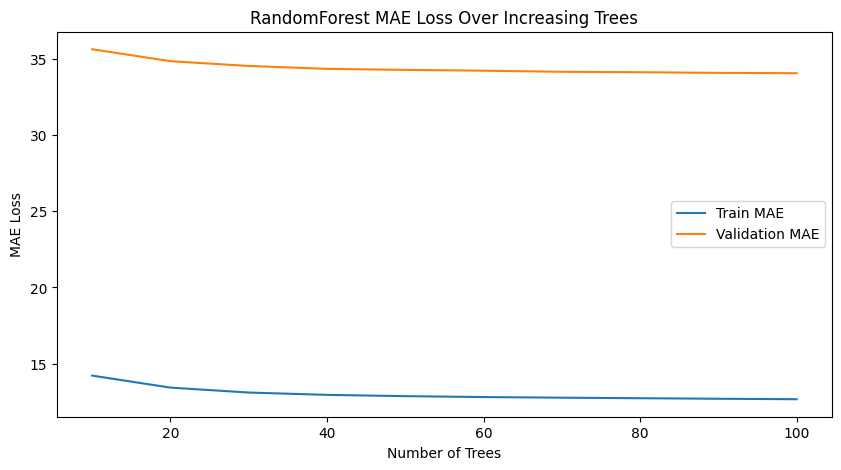

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Settings for demonstration
DEBUG = False  # Set to True for a quicker, less detailed run
n_estimators_step = 10  # Step size for increasing n_estimators
max_estimators = 100 #if DEBUG else 1500  # Max number of trees
train_mae = []
val_mae = []

# Iterative training of RandomForest
for n_trees in range(n_estimators_step, max_estimators + 1, n_estimators_step):
    clf = RandomForestRegressor(n_estimators=n_trees, random_state=42)
    
    # Training the model
    clf.fit(X_train_all, y_train_all)
    
    # Evaluating on training set
    train_predictions = clf.predict(X_train_all)
    train_mae.append(mean_absolute_error(y_train_all, train_predictions))
    
    # Evaluating on validation set
    val_predictions = clf.predict(X_test_all)
    val_mae.append(mean_absolute_error(y_test_all, val_predictions))

    # Verbose output
    print(f"Trained with {n_trees} trees: Train MAE = {train_mae[-1]}, Validation MAE = {val_mae[-1]}")

    # Early stopping criterion (optional)
    # if len(val_mae) > 2 and val_mae[-1] > val_mae[-2]:
    #     break

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(range(n_estimators_step, n_estimators_step * len(train_mae) + 1, n_estimators_step), train_mae, label='Train MAE')
plt.plot(range(n_estimators_step, n_estimators_step * len(val_mae) + 1, n_estimators_step), val_mae, label='Validation MAE')
plt.xlabel('Number of Trees')
plt.ylabel('MAE Loss')
plt.title('RandomForest MAE Loss Over Increasing Trees')
plt.legend()
plt.show()


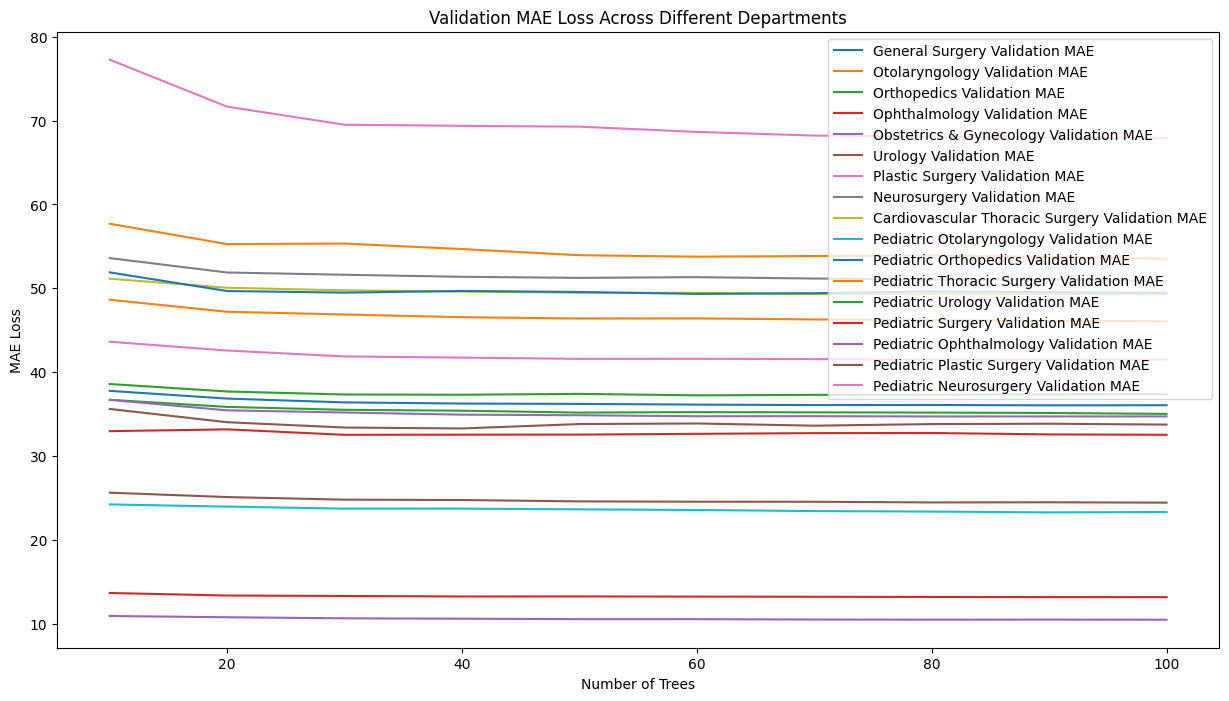

In [13]:
from sklearn.model_selection import train_test_split

# 가정: df_encoded, df 및 기타 필요한 데이터가 이미 로드되어 있음

# 분과별 데이터셋 준비
departments = df['surgical_department'].unique()

# 분과별 모델 훈련 및 검증 결과 저장을 위한 딕셔너리
dept_train_mae = {}
dept_val_mae = {}

# 설정
n_estimators_step = 10
max_estimators = 100  # 예시를 위해 낮은 값 사용

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # 데이터 분할
    X_train_dept, X_val_dept, y_train_dept, y_val_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 각 분과별 MAE 저장을 위한 리스트
    train_mae = []
    val_mae = []

    # 나무 수 증가에 따른 반복 학습
    for n_trees in range(n_estimators_step, max_estimators + 1, n_estimators_step):
        model = RandomForestRegressor(n_estimators=n_trees, random_state=42)
        model.fit(X_train_dept, y_train_dept)

        # 훈련 및 검증 세트에 대한 MAE 계산
        train_mae.append(mean_absolute_error(y_train_dept, model.predict(X_train_dept)))
        val_mae.append(mean_absolute_error(y_val_dept, model.predict(X_val_dept)))

    # 결과 저장
    dept_train_mae[dept] = train_mae
    dept_val_mae[dept] = val_mae

# 각 분과별 MAE 성능 시각화
plt.figure(figsize=(15, 8))

for dept in departments:
    if dept in dept_train_mae:
        plt.plot(range(n_estimators_step, max_estimators + 1, n_estimators_step), dept_val_mae[dept], label=f'{dept} Validation MAE')

plt.xlabel('Number of Trees')
plt.ylabel('MAE Loss')
plt.title('Validation MAE Loss Across Different Departments')
plt.legend()
plt.show()


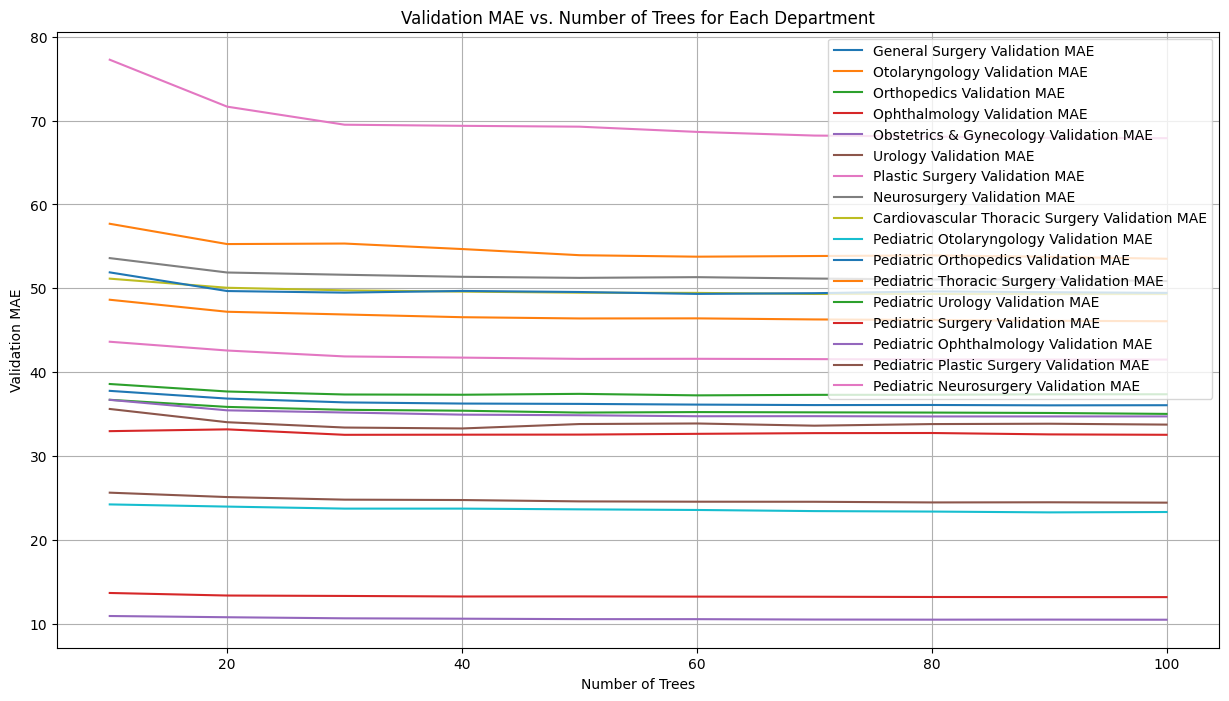

In [17]:
import matplotlib.pyplot as plt

# Plot settings
plt.figure(figsize=(15, 8))

# Iterate over each department and plot the MAE trends
for dept in departments:
    n_trees_range = range(n_estimators_step, max_estimators + 1, n_estimators_step)
    
    # Ensure the department is in the dictionary
    if dept in dept_val_mae:
        plt.plot(n_trees_range, dept_val_mae[dept], label=f'{dept} Validation MAE')

plt.xlabel('Number of Trees')
plt.ylabel('Validation MAE')
plt.title('Validation MAE vs. Number of Trees for Each Department')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
optimal_trees_per_dept = {}

for dept in departments:
    if dept in dept_val_mae:
        val_maes = dept_val_mae[dept]
        # Find the index of the minimum MAE
        min_mae_index = val_maes.index(min(val_maes))
        # Find the corresponding number of trees
        optimal_trees = range(n_estimators_step, max_estimators + 1, n_estimators_step)[min_mae_index]
        optimal_trees_per_dept[dept] = optimal_trees

# Print the optimal number of trees for each department
for dept, trees in optimal_trees_per_dept.items():
    print(f"Optimal number of trees for {dept}: {trees}")


Optimal number of trees for General Surgery: 90
Optimal number of trees for Otolaryngology: 100
Optimal number of trees for Orthopedics: 100
Optimal number of trees for Ophthalmology: 100
Optimal number of trees for Obstetrics & Gynecology: 80
Optimal number of trees for Urology: 100
Optimal number of trees for Plastic Surgery: 90
Optimal number of trees for Neurosurgery: 100
Optimal number of trees for Cardiovascular Thoracic Surgery: 90
Optimal number of trees for Pediatric Otolaryngology: 90
Optimal number of trees for Pediatric Orthopedics: 60
Optimal number of trees for Pediatric Thoracic Surgery: 100
Optimal number of trees for Pediatric Urology: 60
Optimal number of trees for Pediatric Surgery: 30
Optimal number of trees for Pediatric Ophthalmology: 100
Optimal number of trees for Pediatric Plastic Surgery: 40
Optimal number of trees for Pediatric Neurosurgery: 100


In [19]:
# Assuming dept_val_mae stores the validation MAE for each department

# Calculate the average validation MAE for each department
avg_val_mae_per_dept = {dept: sum(maes)/len(maes) for dept, maes in dept_val_mae.items()}

# Sort departments by their average validation MAE
sorted_depts_by_error = sorted(avg_val_mae_per_dept.items(), key=lambda x: x[1], reverse=True)

# Print departments with the highest errors
print("Departments with the highest average validation MAE:")
for dept, mae in sorted_depts_by_error:
    print(f"{dept}: {mae}")


Departments with the highest average validation MAE:
Pediatric Neurosurgery: 69.78104307420975
Pediatric Thoracic Surgery: 54.57351042722054
Neurosurgery: 51.51570959997351
Pediatric Orthopedics: 49.76535300693048
Cardiovascular Thoracic Surgery: 49.67782131604202
Otolaryngology: 46.680335139689284
Plastic Surgery: 41.908847876561964
Pediatric Urology: 37.49336165799653
General Surgery: 36.392334857743485
Orthopedics: 35.44889095300174
Obstetrics & Gynecology: 35.083475219960555
Pediatric Plastic Surgery: 33.90954848739496
Pediatric Surgery: 32.706023567977915
Urology: 24.744659427599995
Pediatric Otolaryngology: 23.636413231872687
Ophthalmology: 13.297902711791902
Pediatric Ophthalmology: 10.613879427682864


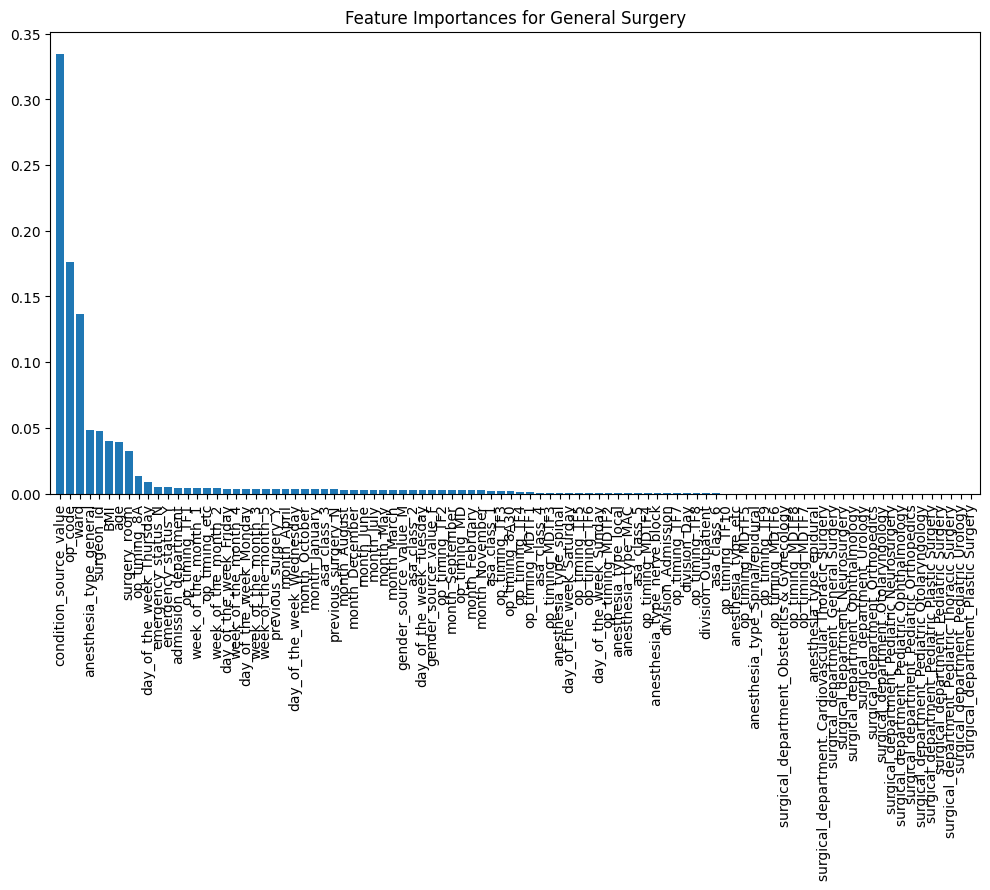

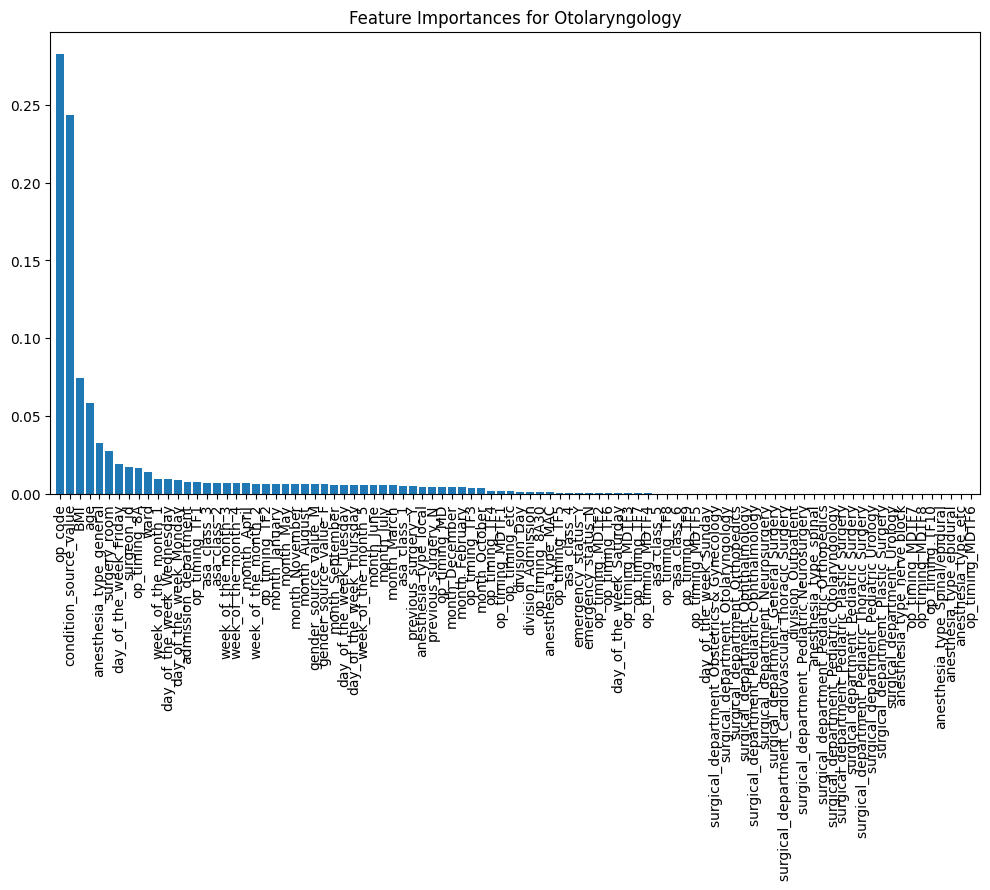

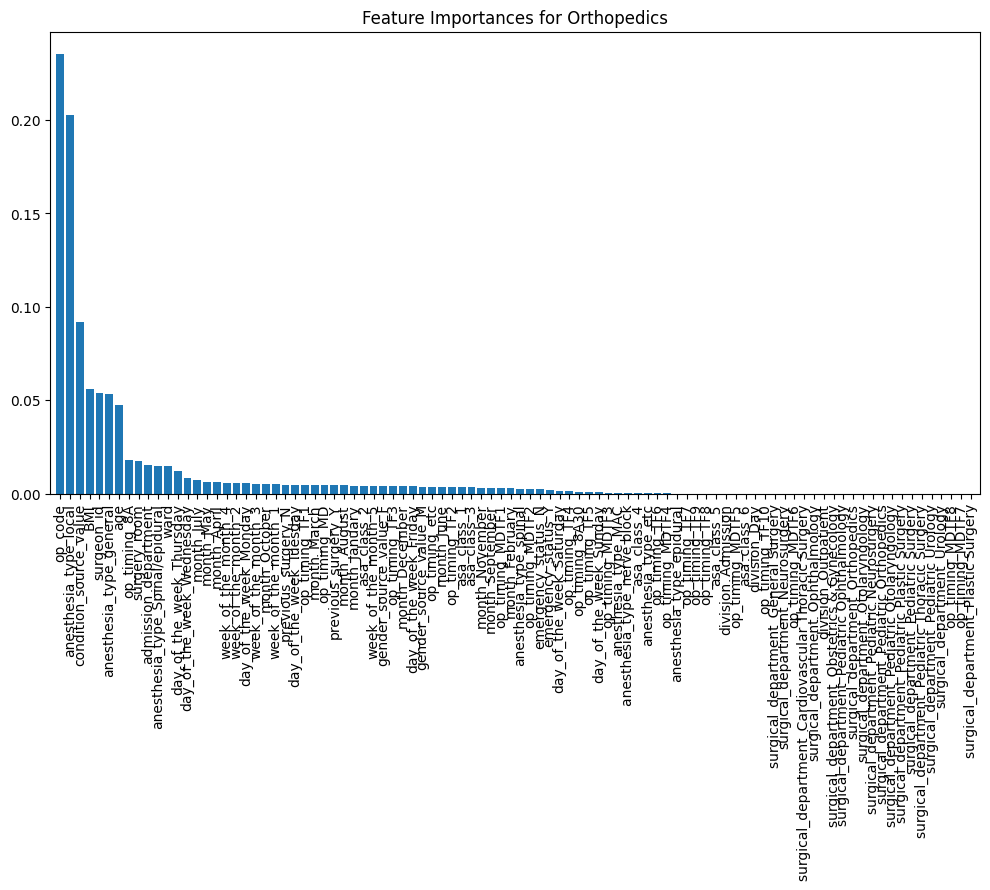

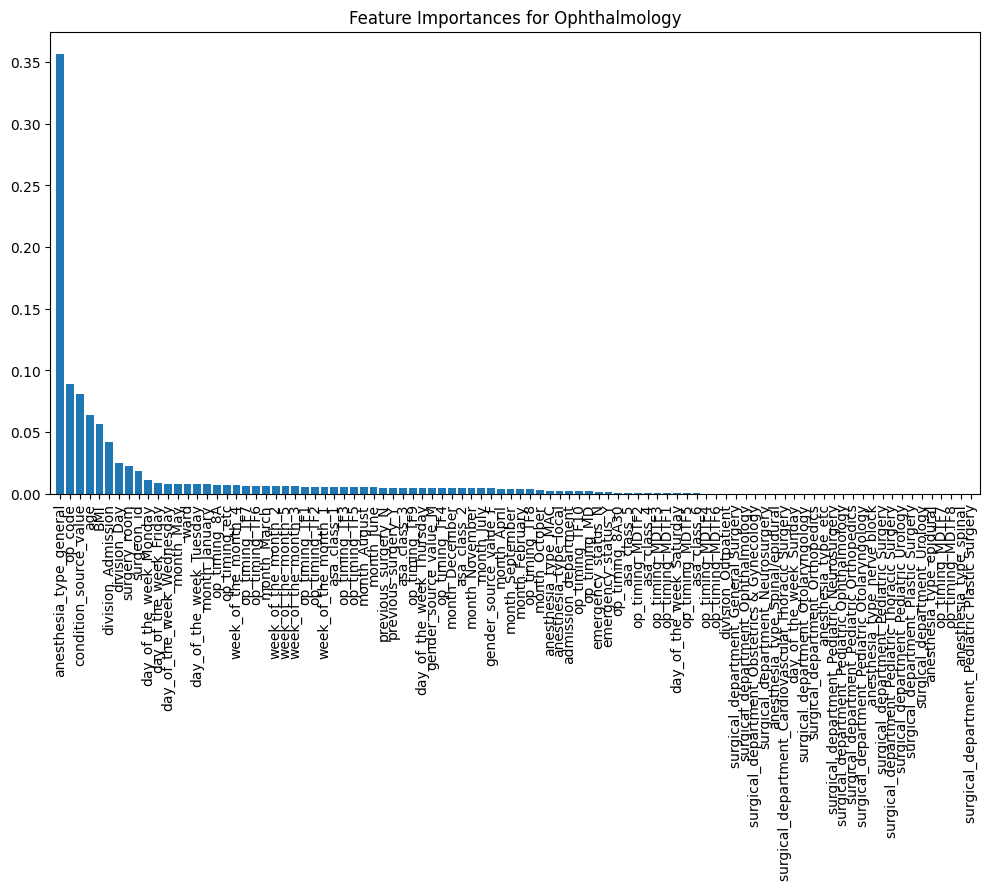

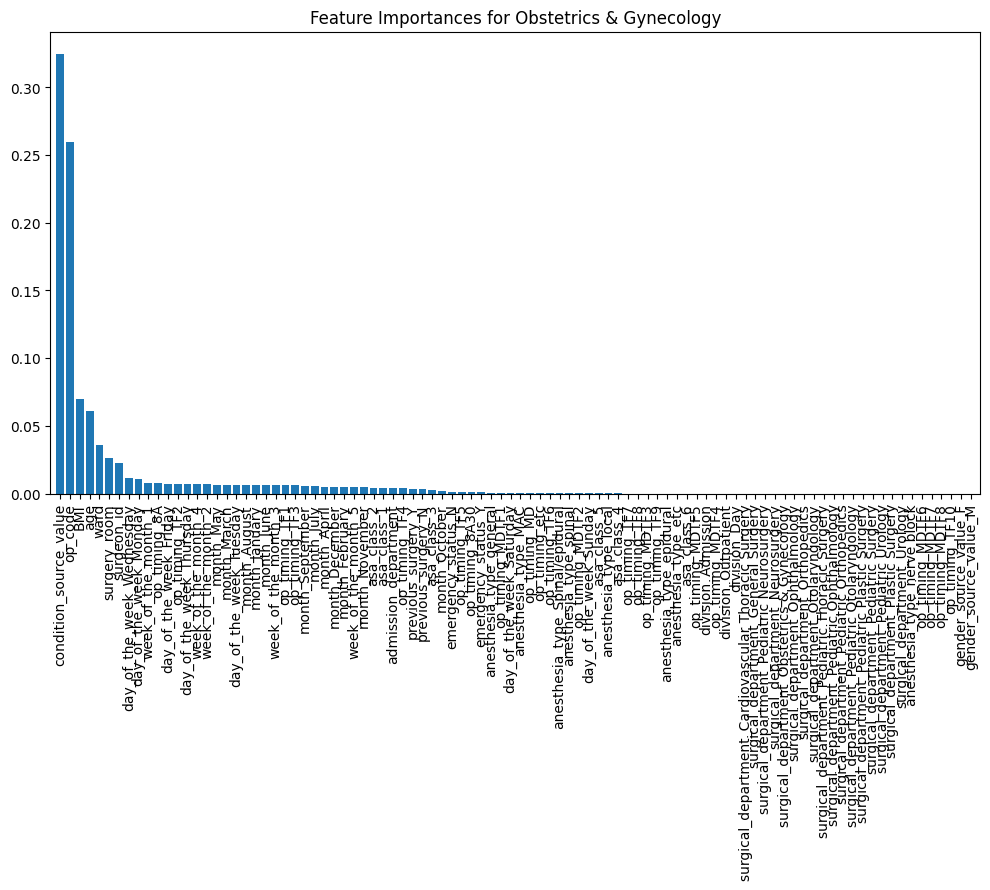

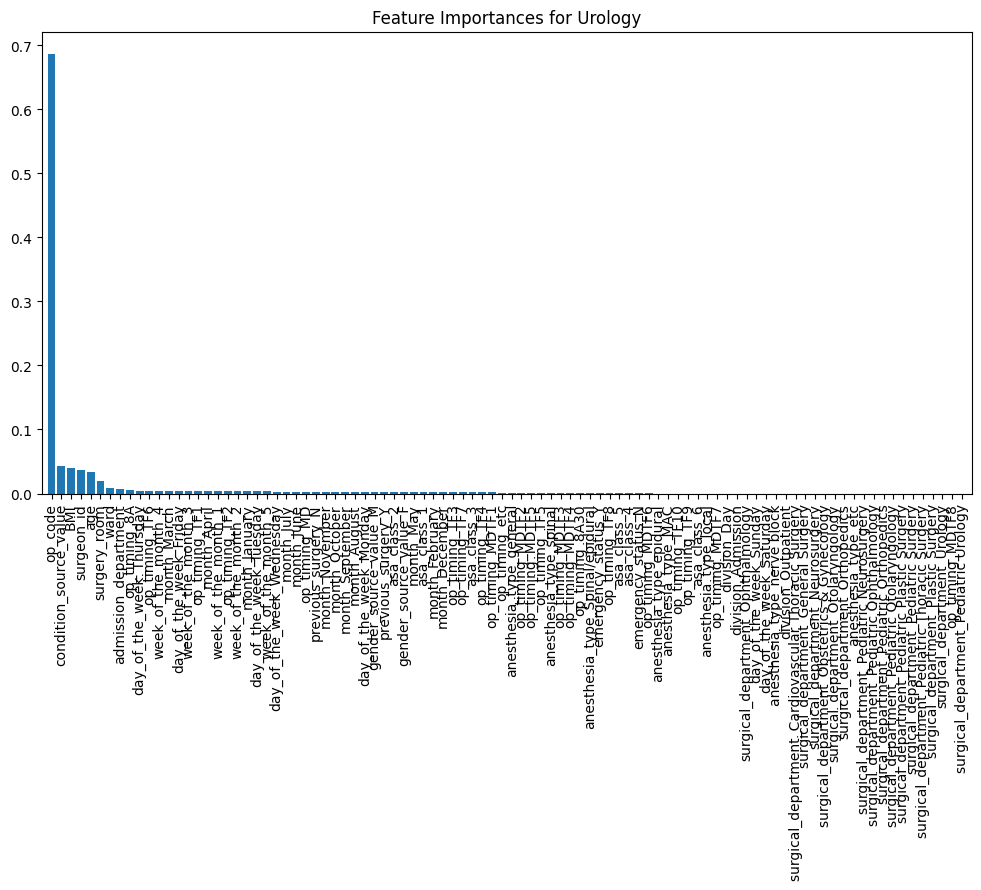

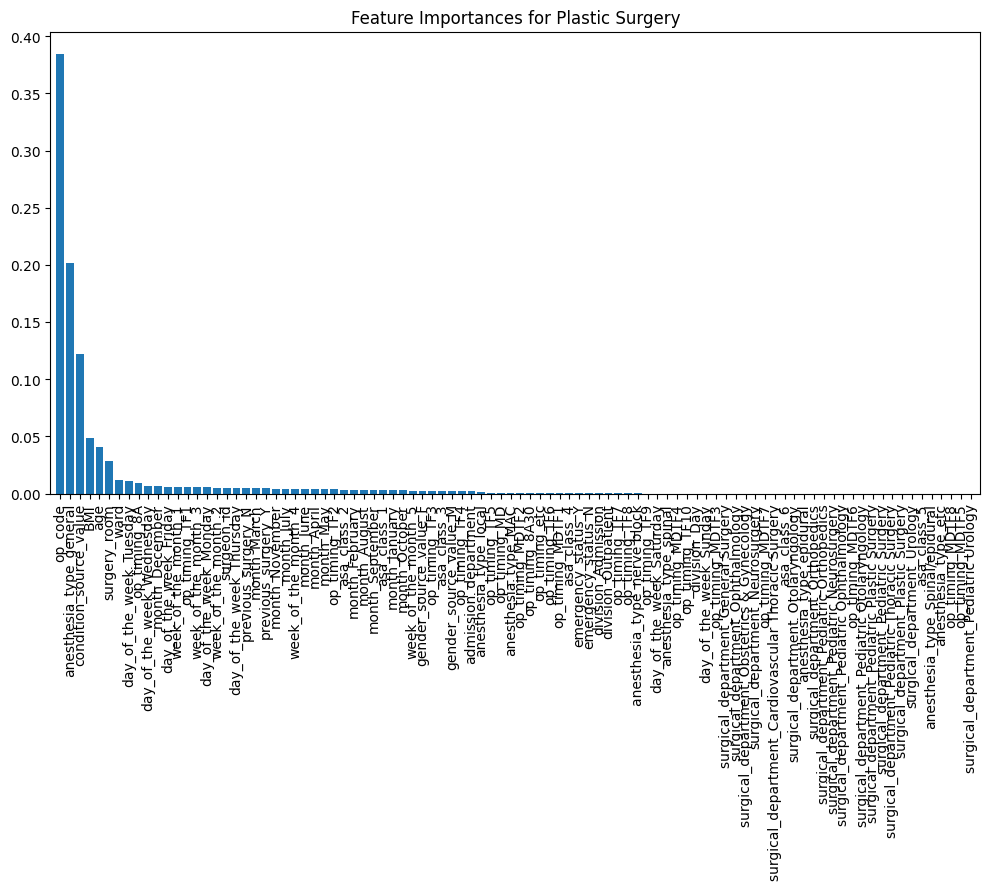

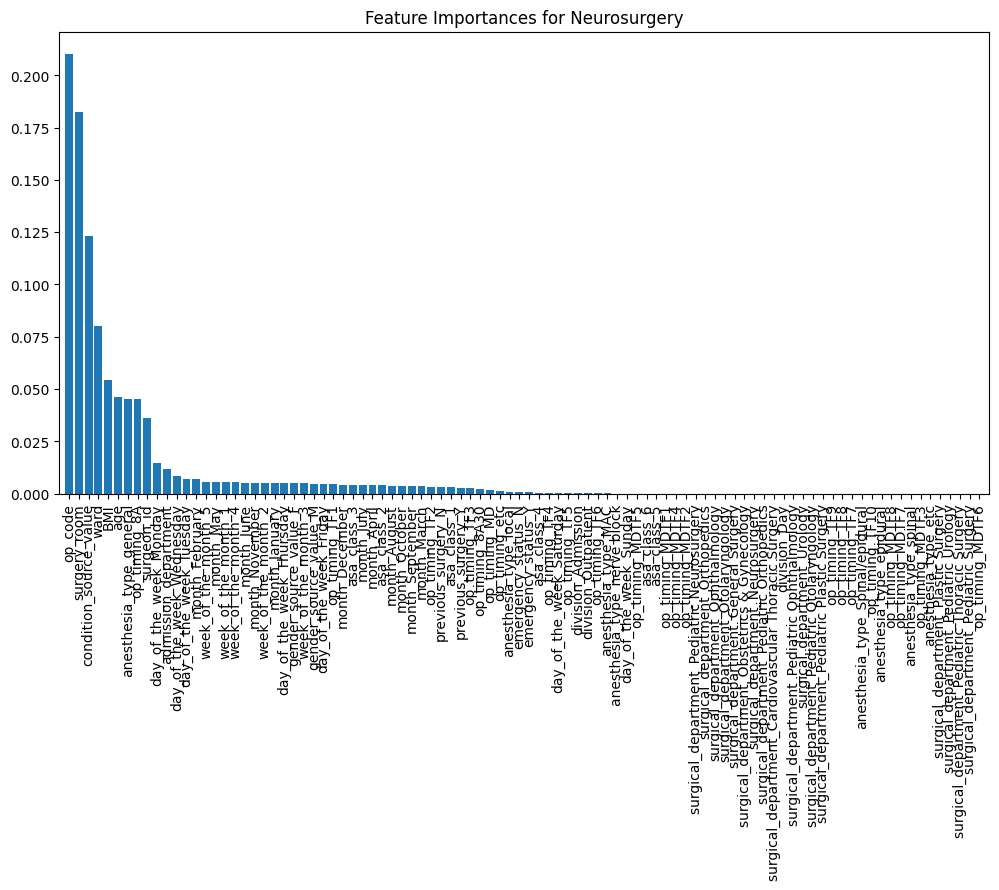

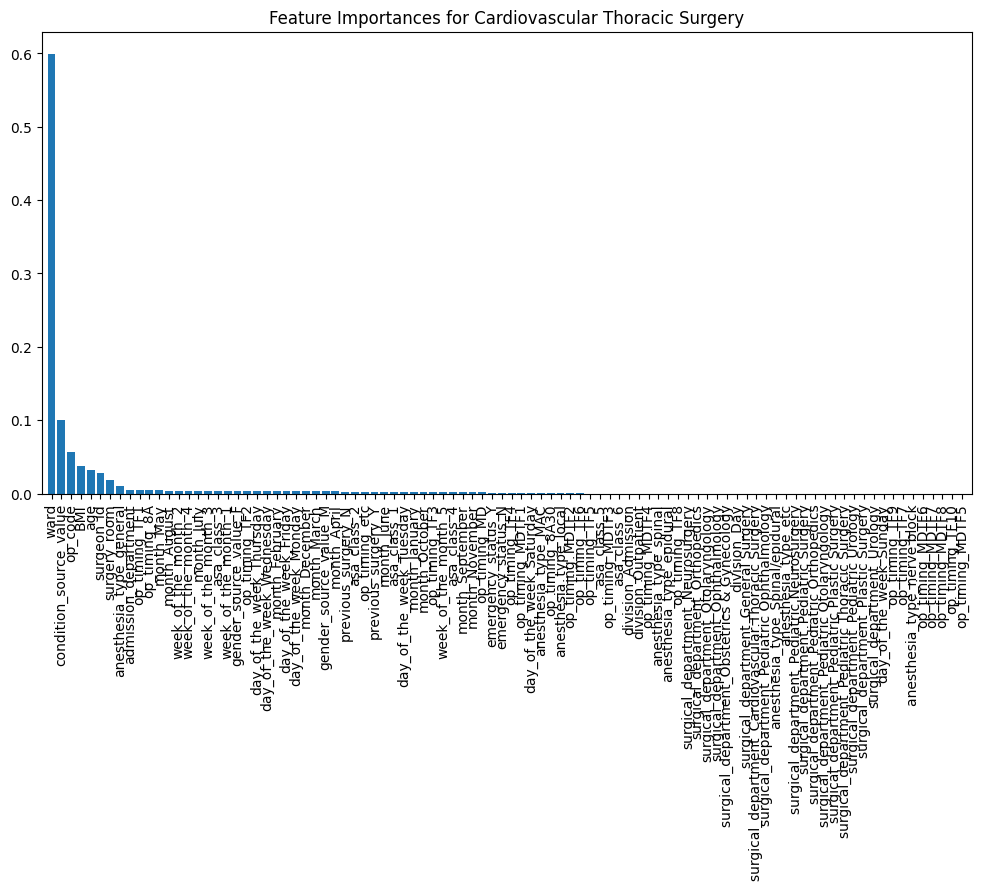

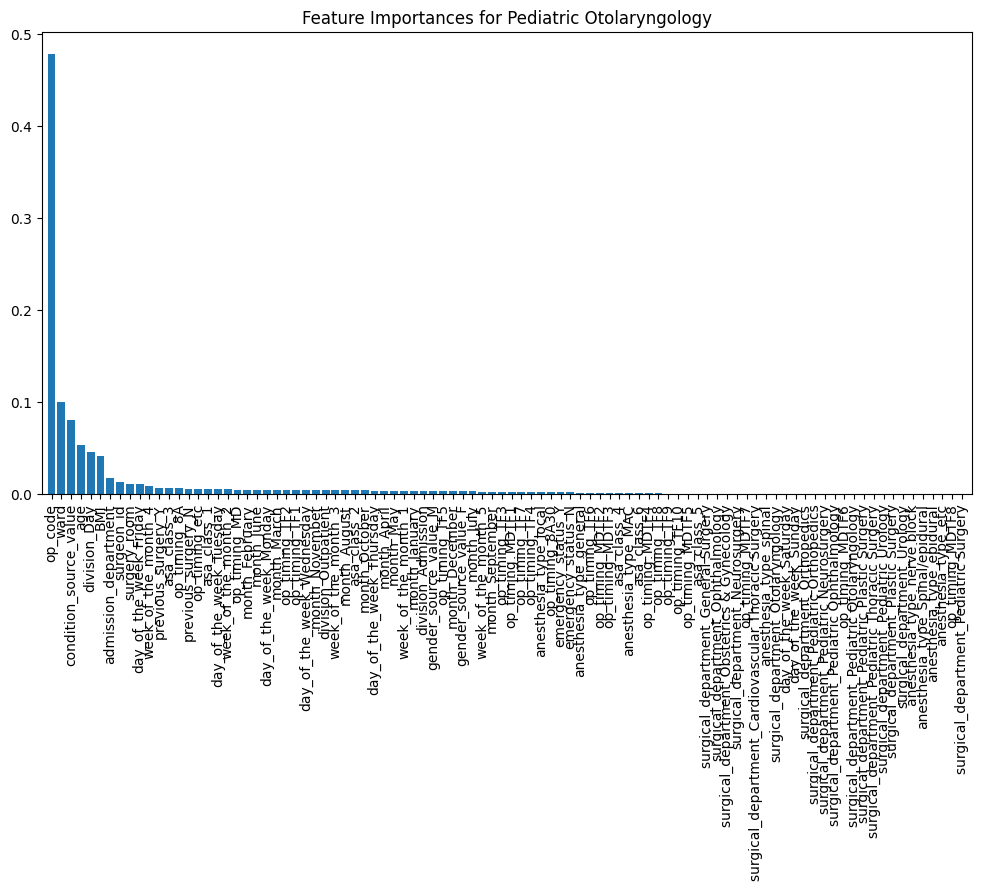

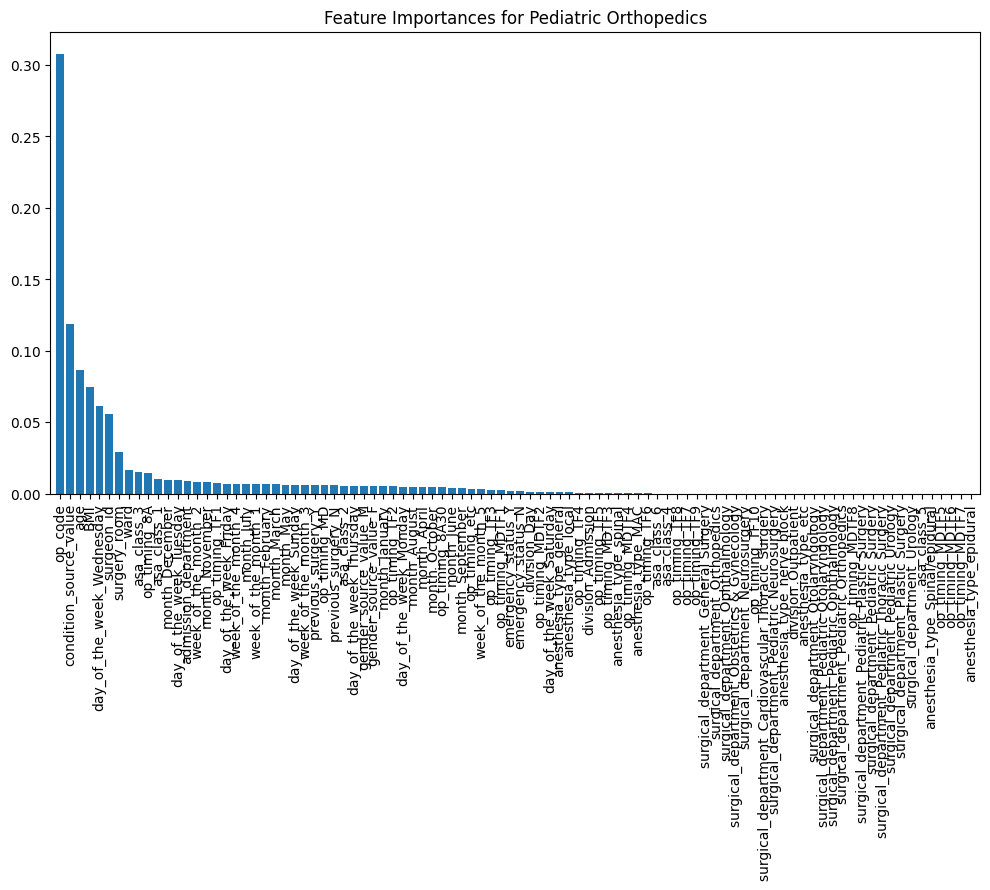

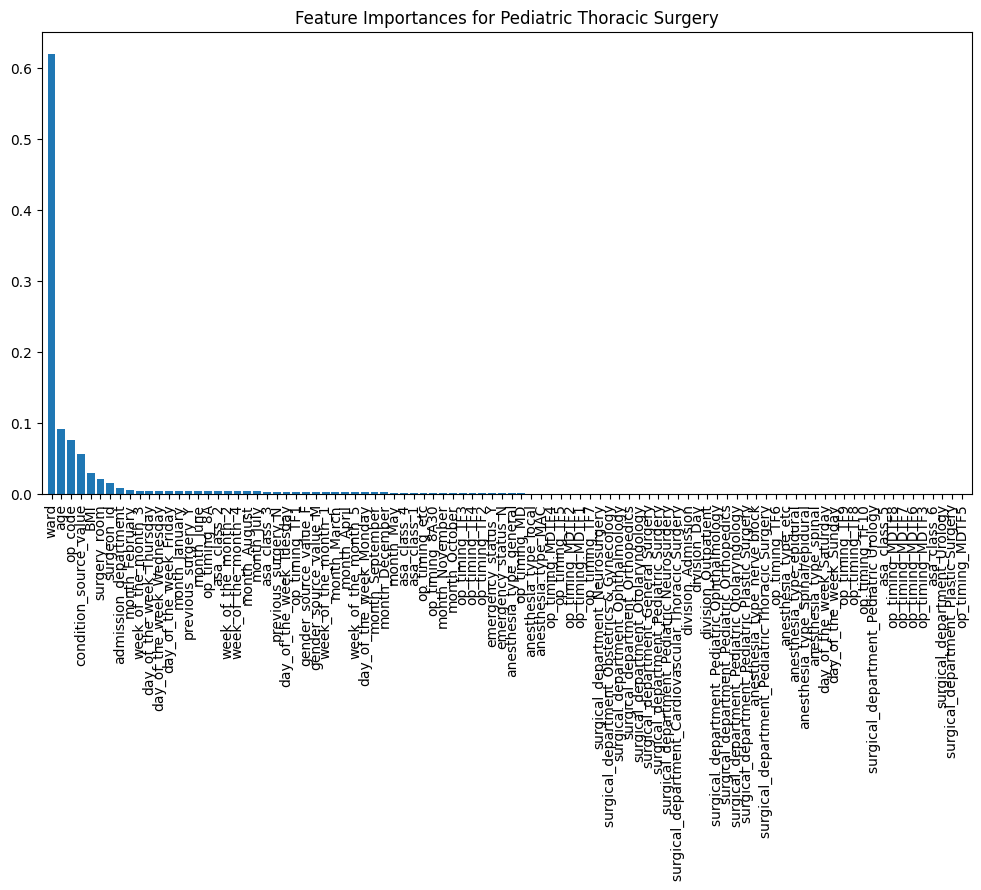

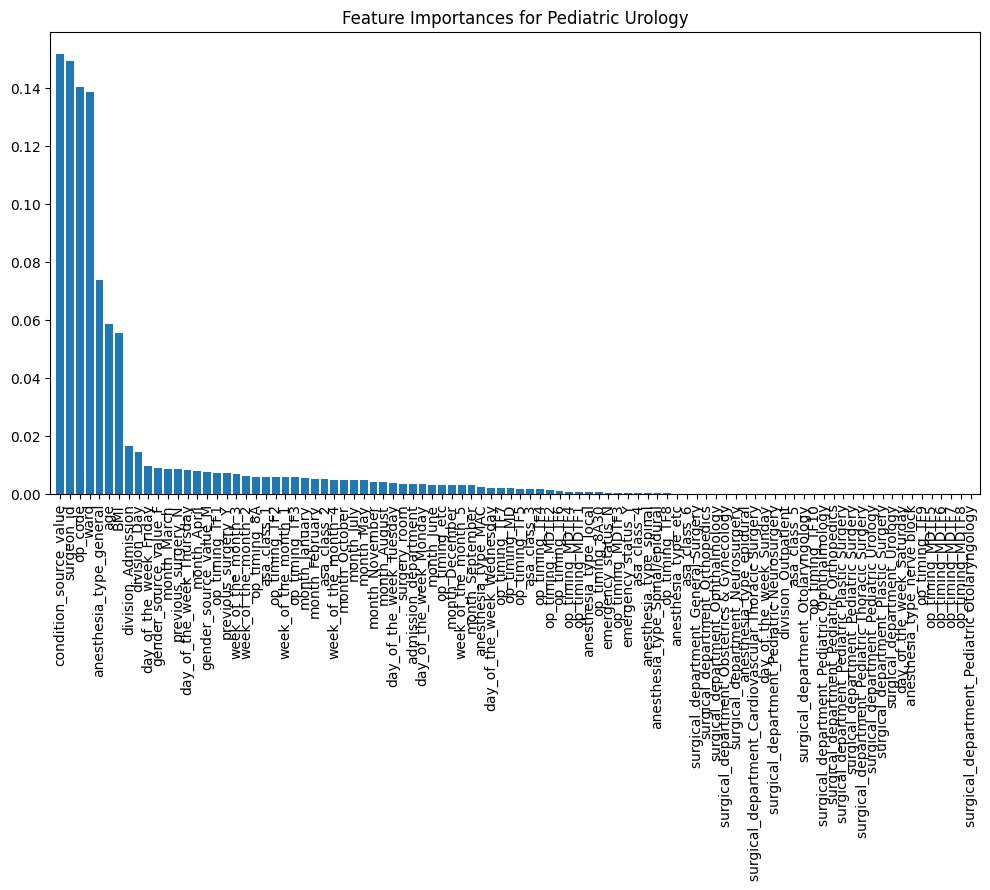

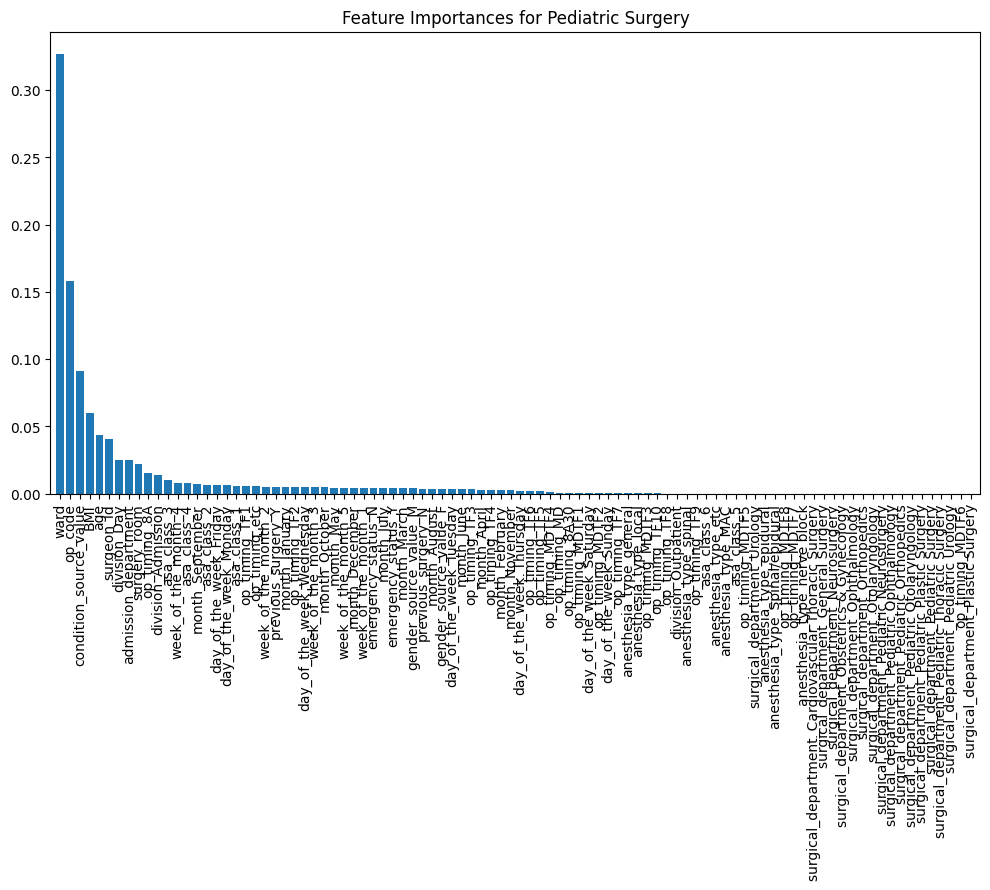

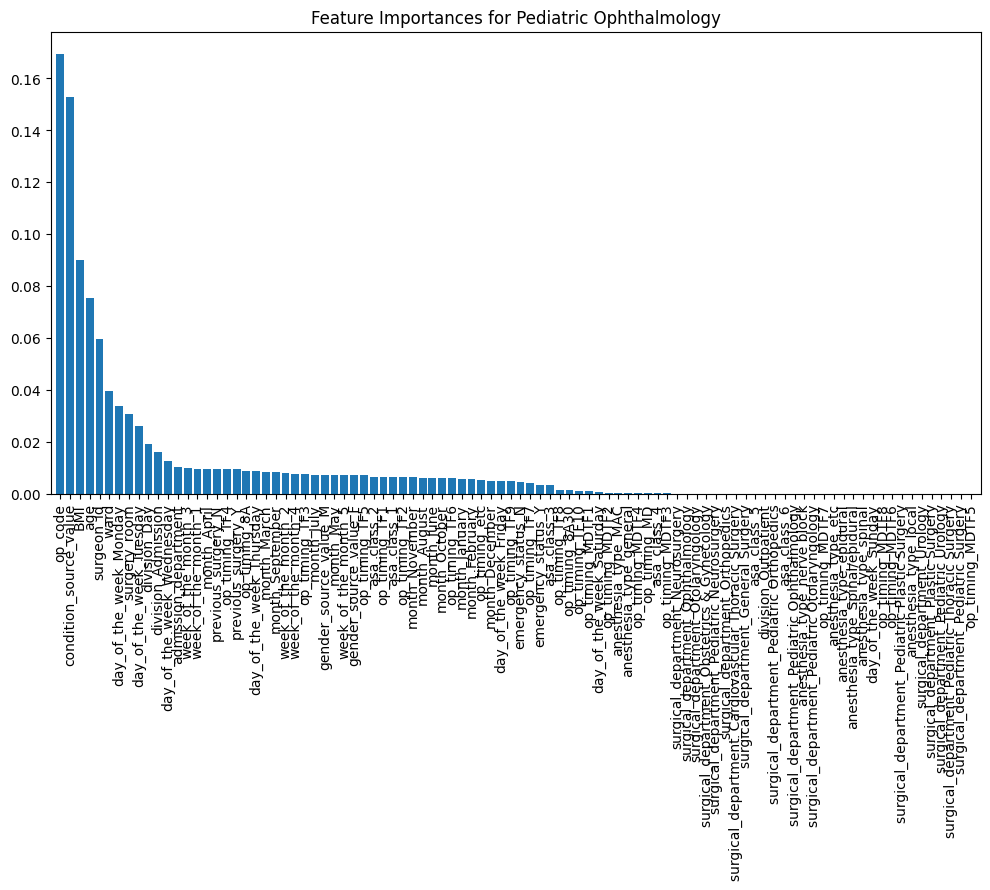

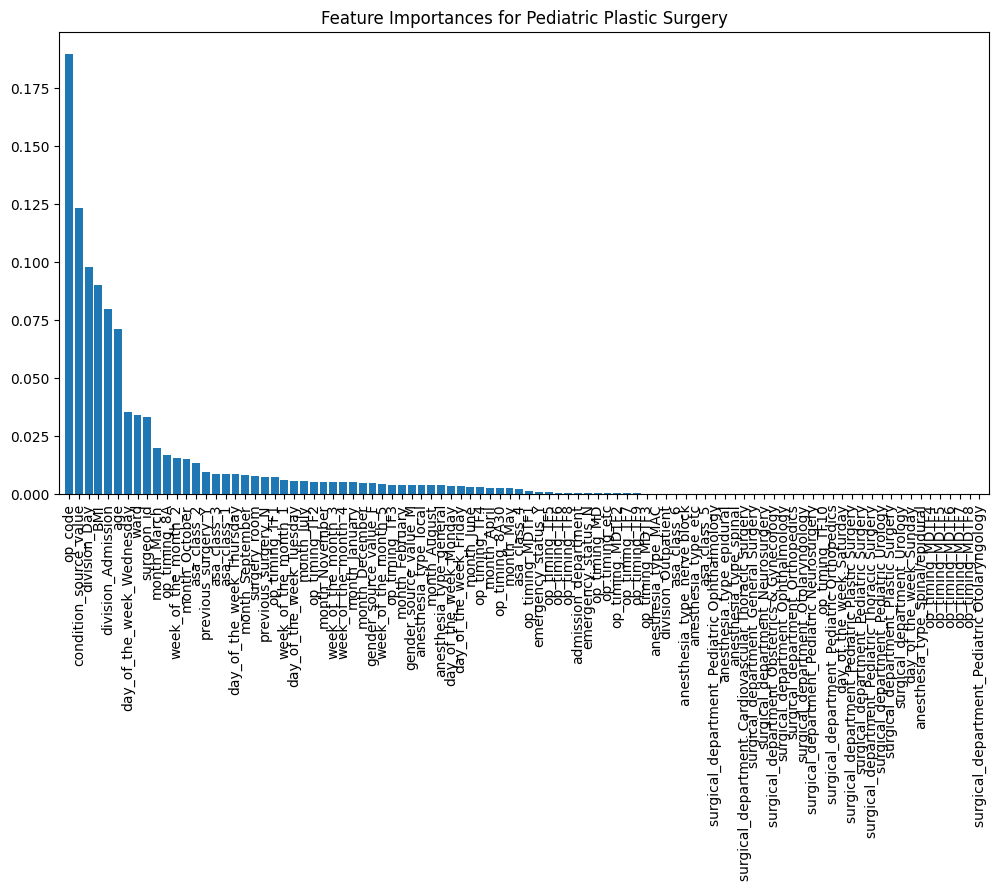

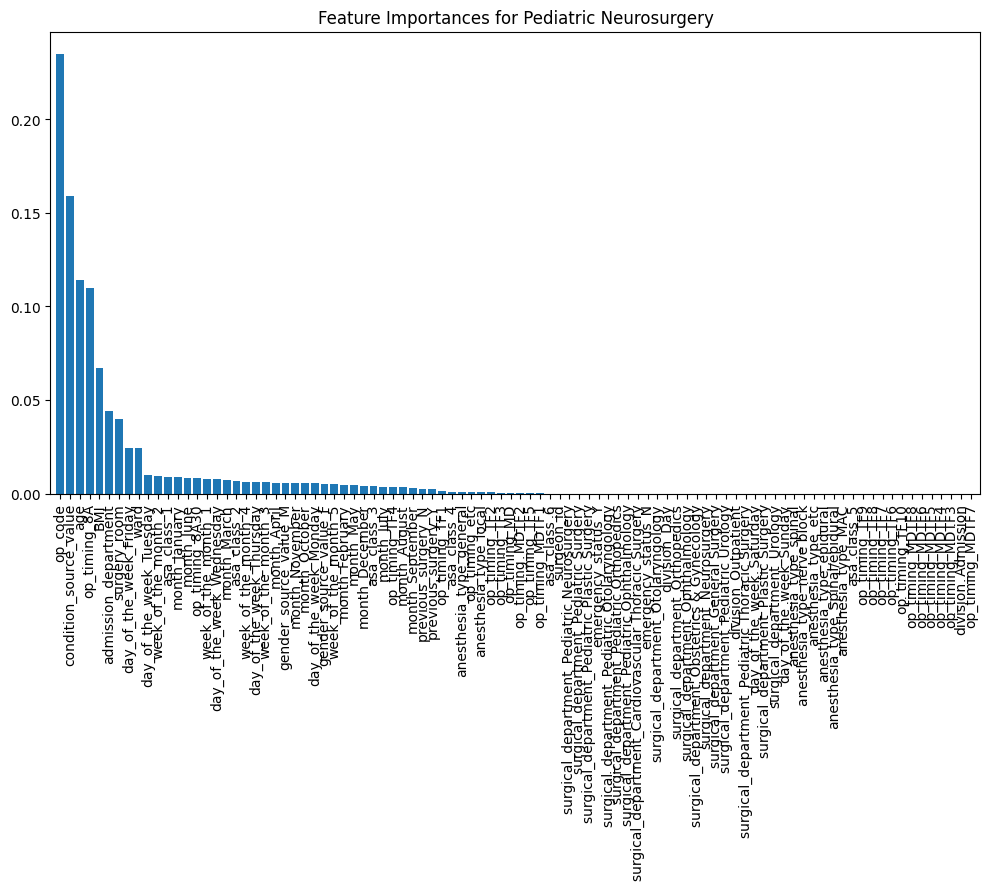

In [20]:
import matplotlib.pyplot as plt

# Assuming each department's model is stored in a dictionary `models`
for dept, model in models.items():
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importances for {dept}")
    plt.bar(range(X_train_dept.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train_dept.shape[1]), X_train_dept.columns[indices], rotation=90)
    plt.xlim([-1, X_train_dept.shape[1]])
    plt.show()


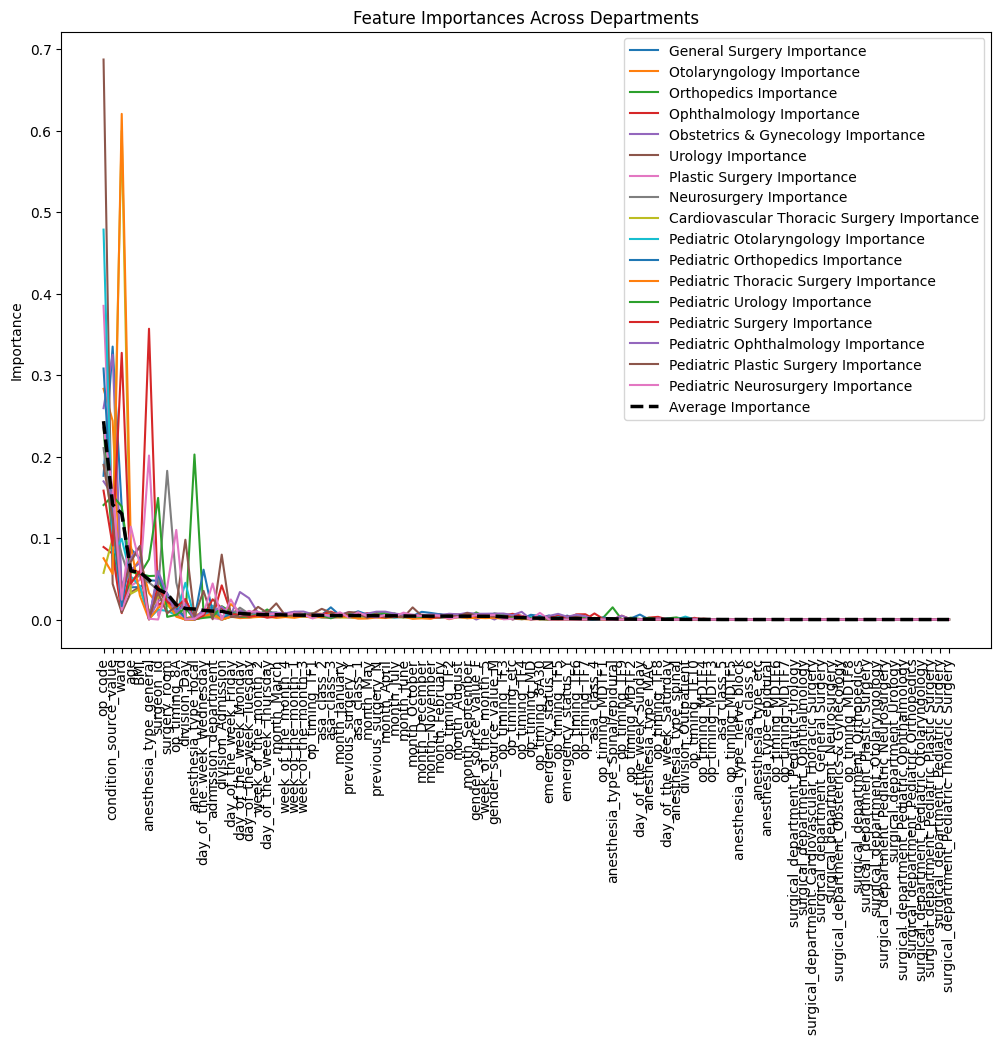

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a DataFrame to store aggregated feature importances
feature_importances = pd.DataFrame(index=X_train_dept.columns)

# Aggregate feature importances from each department's model
for dept, model in models.items():
    feature_importances[dept] = model.feature_importances_

# Calculate the average importance for each feature across all departments
feature_importances['average'] = feature_importances.mean(axis=1)

# Sort the features by their average importance
feature_importances = feature_importances.sort_values(by='average', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
for dept in departments:
    plt.plot(feature_importances.index, feature_importances[dept], label=f'{dept} Importance')
plt.plot(feature_importances.index, feature_importances['average'], label='Average Importance', color='black', linewidth=2.5, linestyle='--')
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importances Across Departments')
plt.legend()
plt.show()


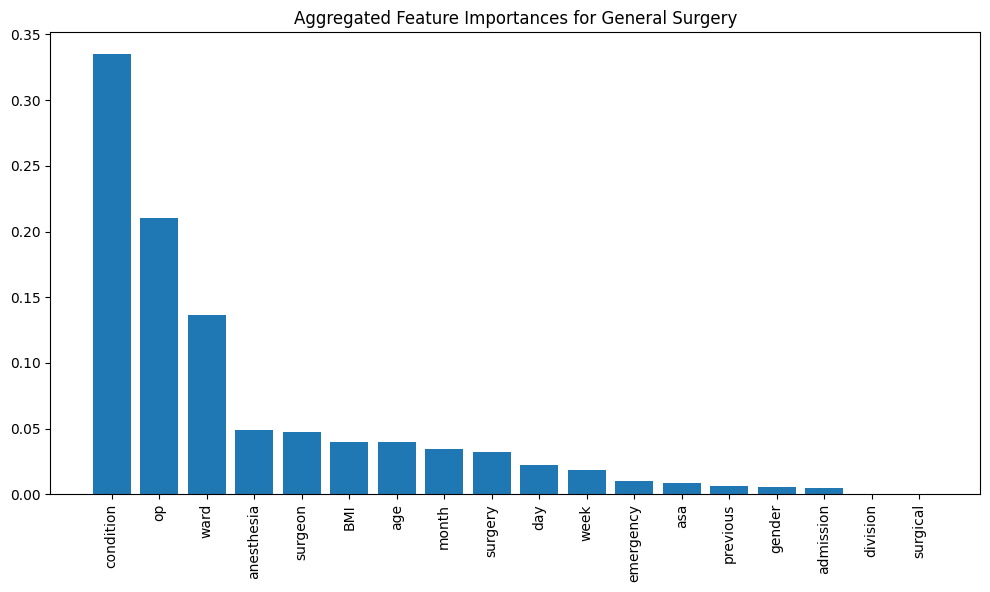

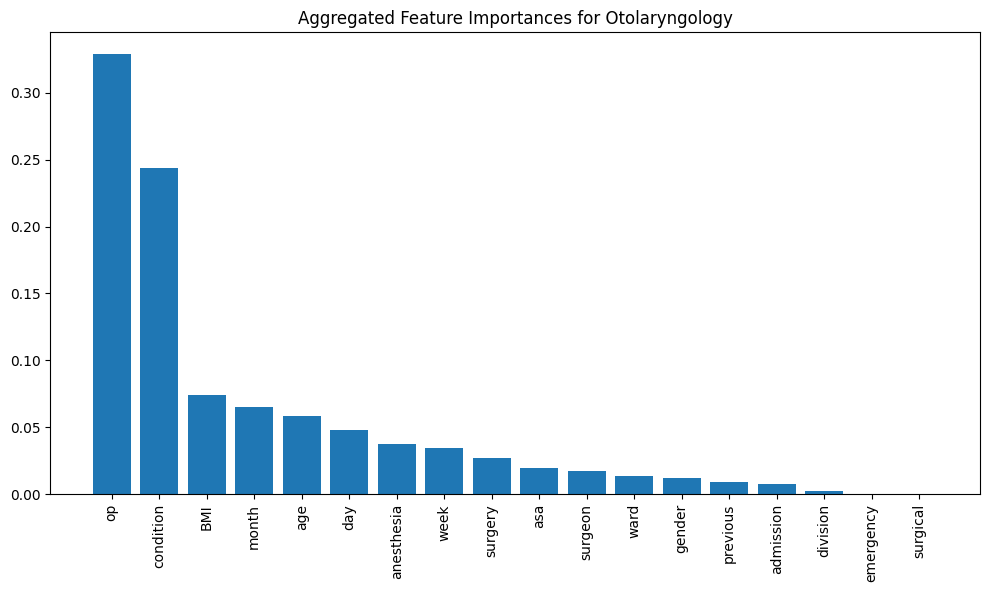

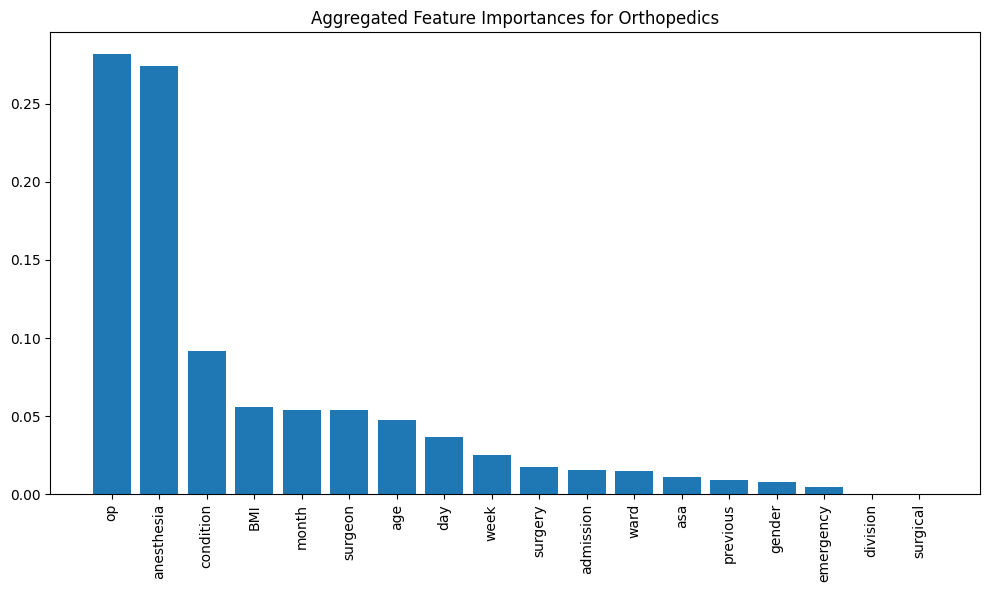

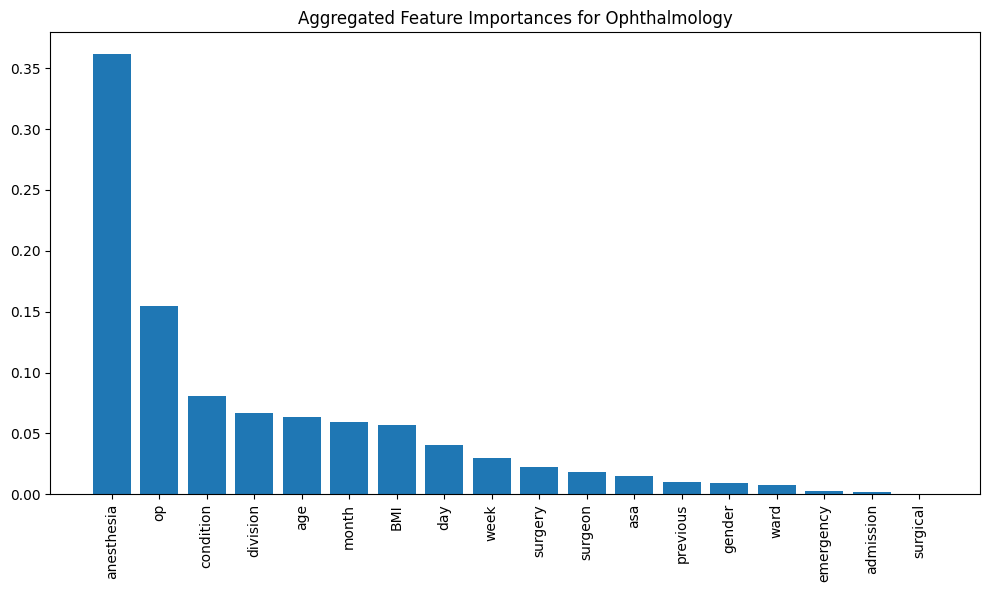

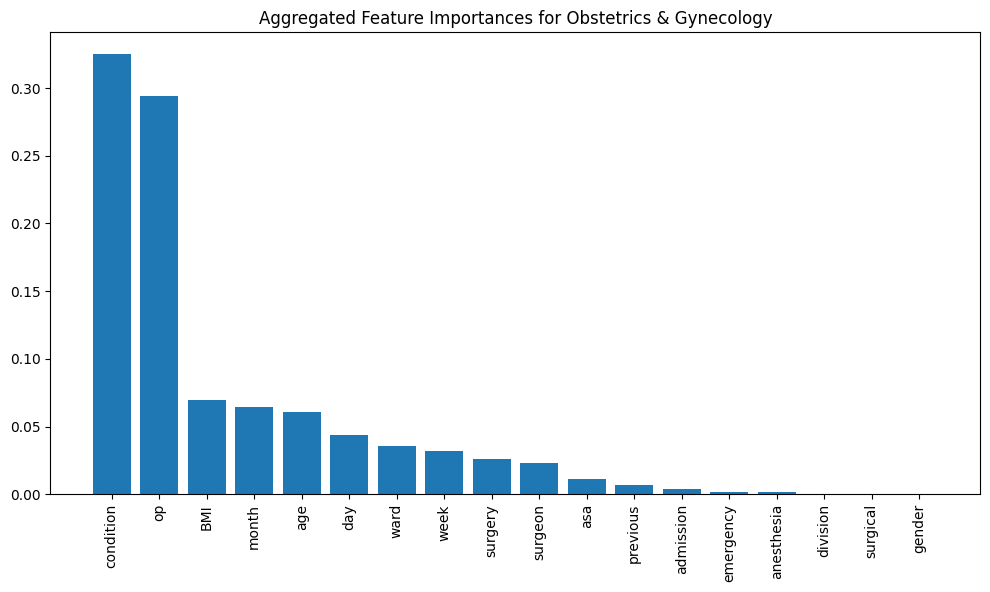

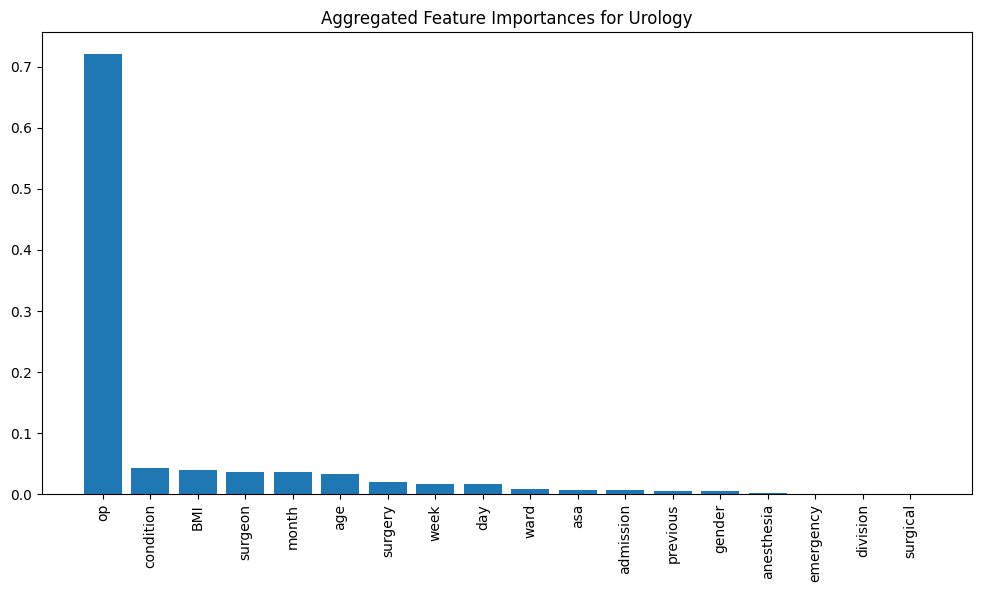

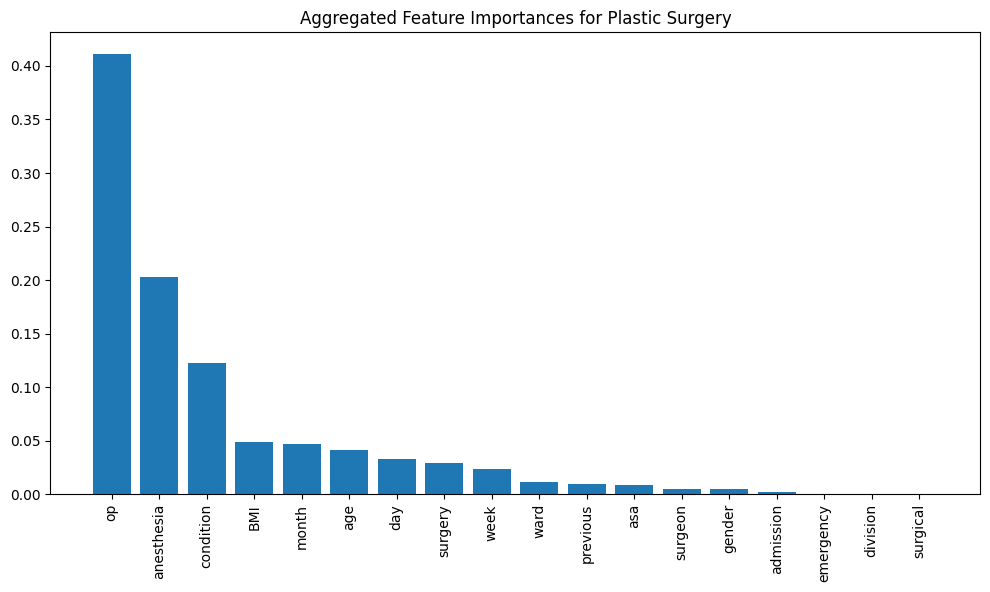

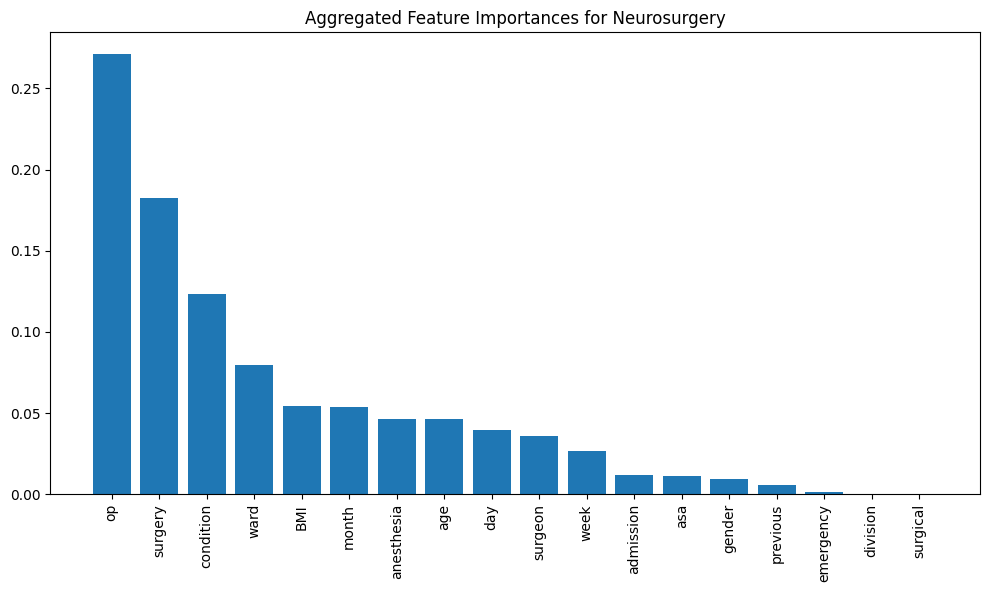

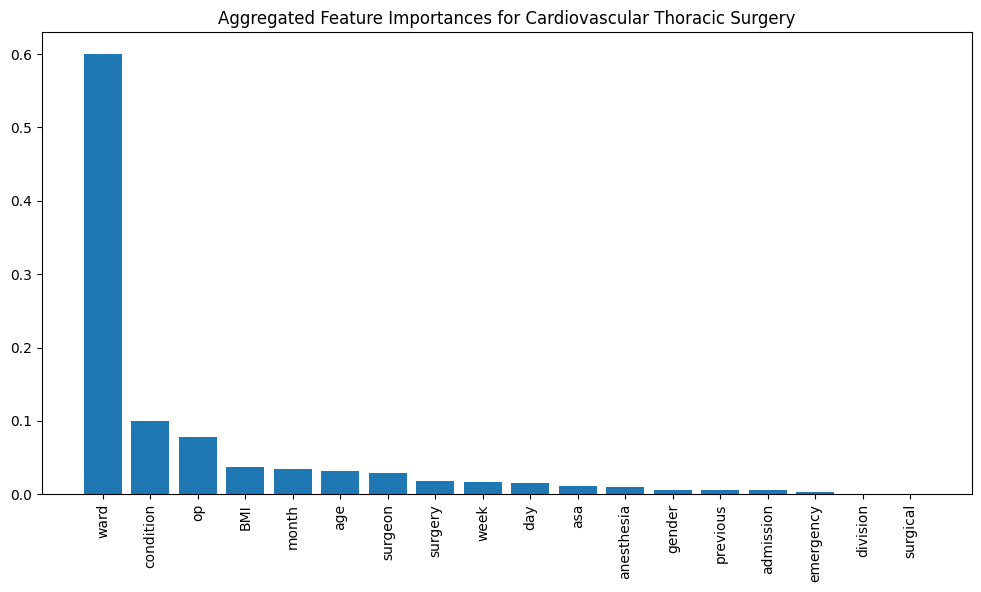

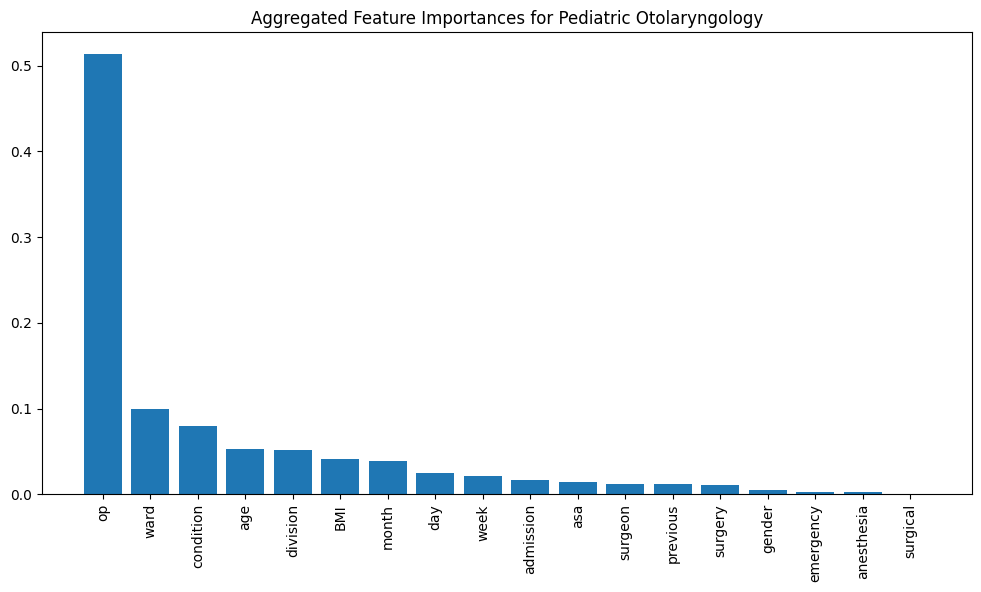

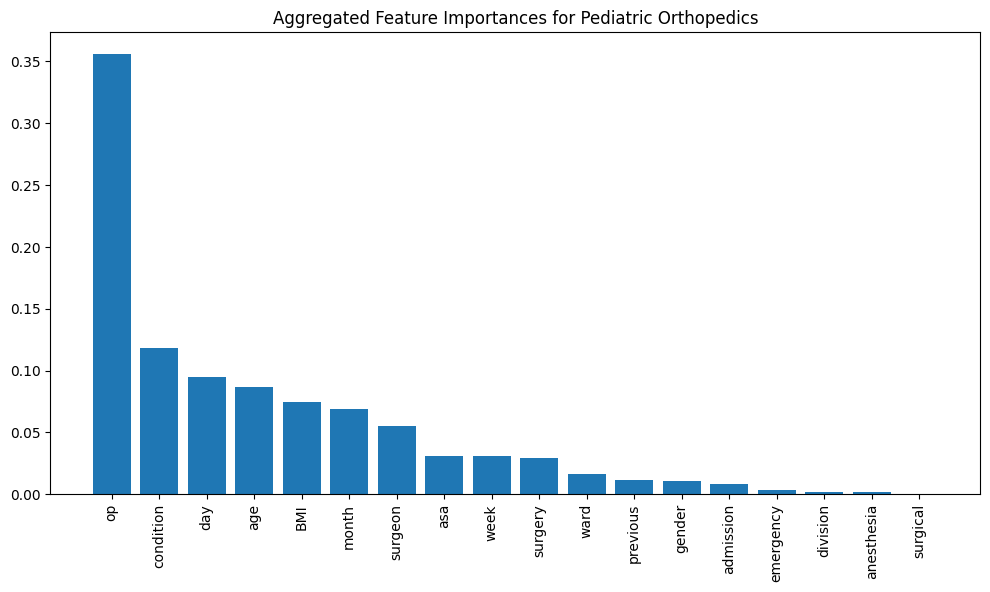

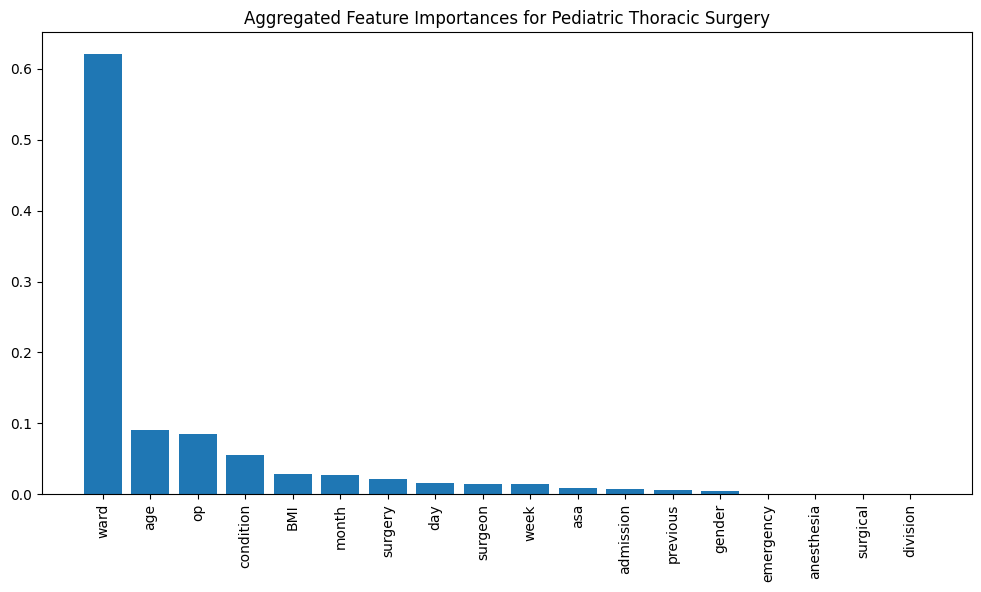

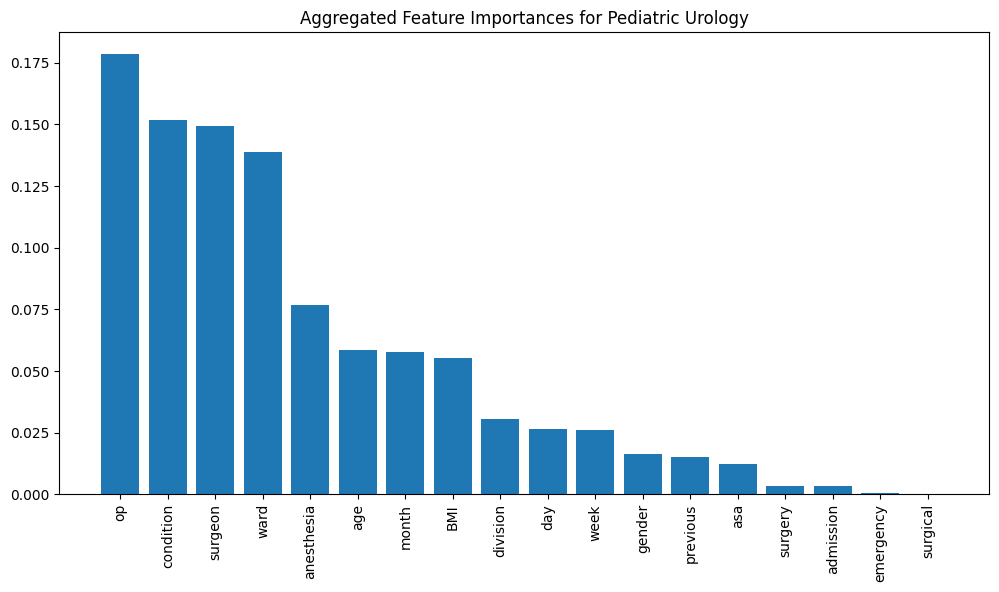

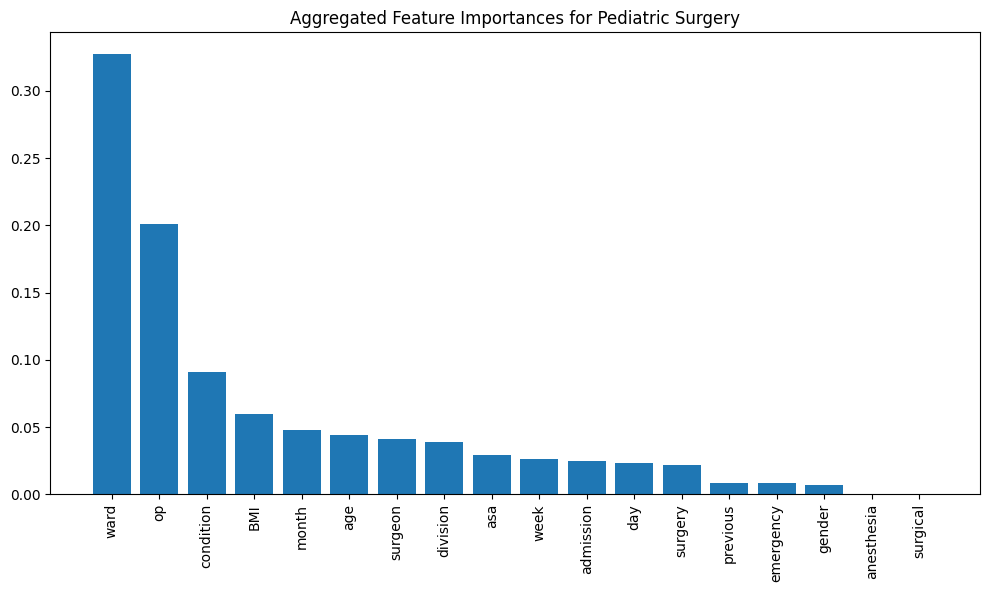

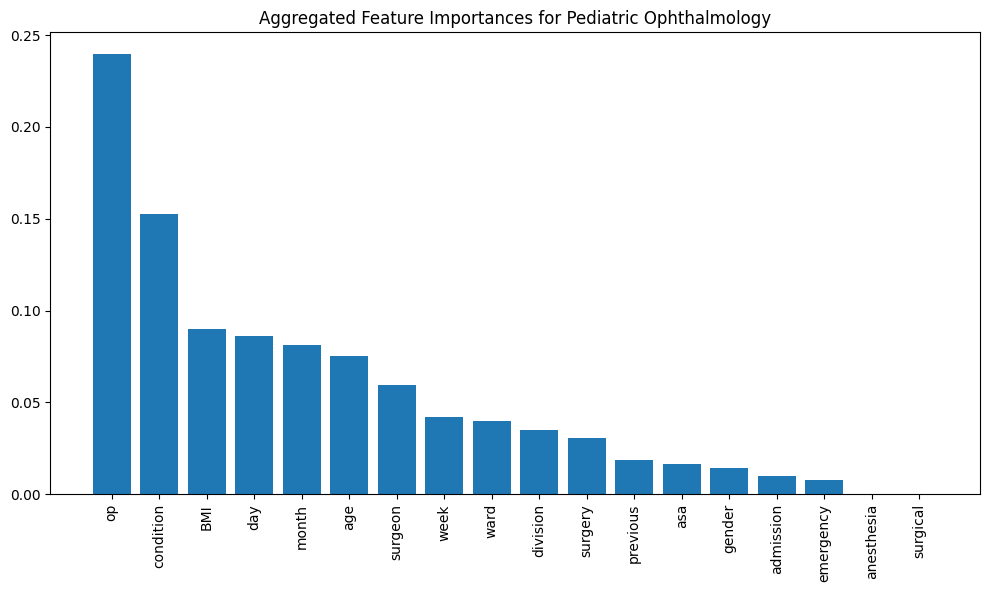

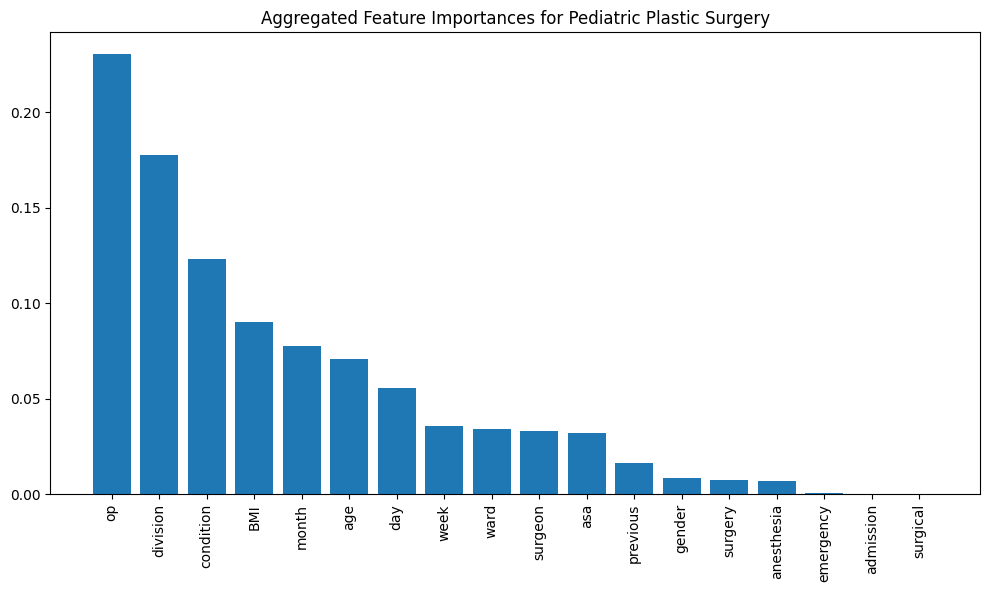

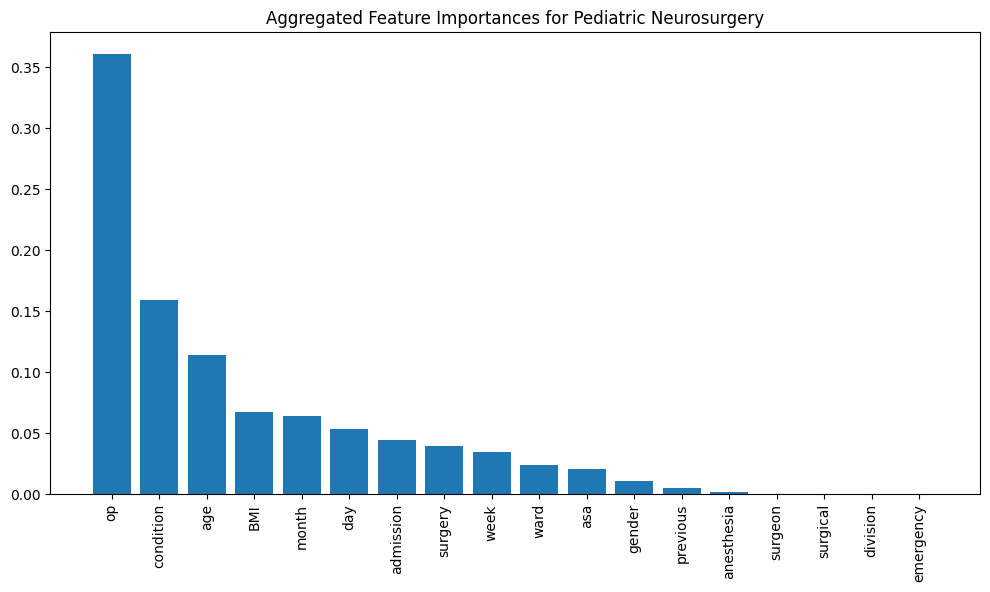

In [22]:
for dept, model in models.items():
    # Get feature importances
    importances = model.feature_importances_

    # Aggregate importances for one-hot encoded features
    aggregated_importances = {}
    for i, col in enumerate(X_train_dept.columns):
        original_feature = col.split('_')[0]  # 원래 피처 이름 추출
        if original_feature not in aggregated_importances:
            aggregated_importances[original_feature] = 0
        aggregated_importances[original_feature] += importances[i]

    # Sort the aggregated importances in descending order
    sorted_importances = sorted(aggregated_importances.items(), key=lambda x: x[1], reverse=True)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(f"Aggregated Feature Importances for {dept}")
    plt.bar(range(len(sorted_importances)), [val for key, val in sorted_importances], align="center")
    plt.xticks(range(len(sorted_importances)), [key for key, val in sorted_importances], rotation=90)
    plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


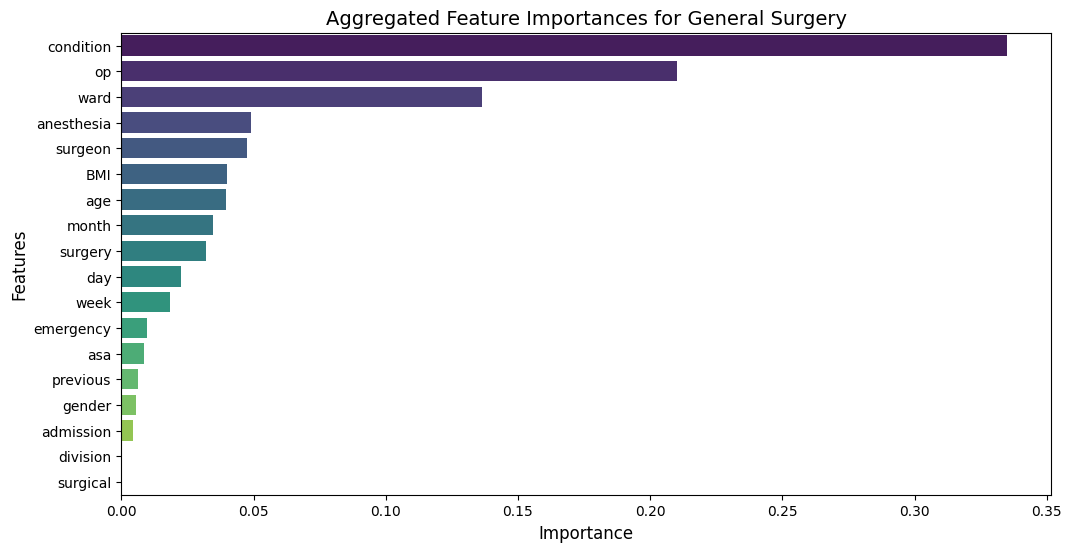

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


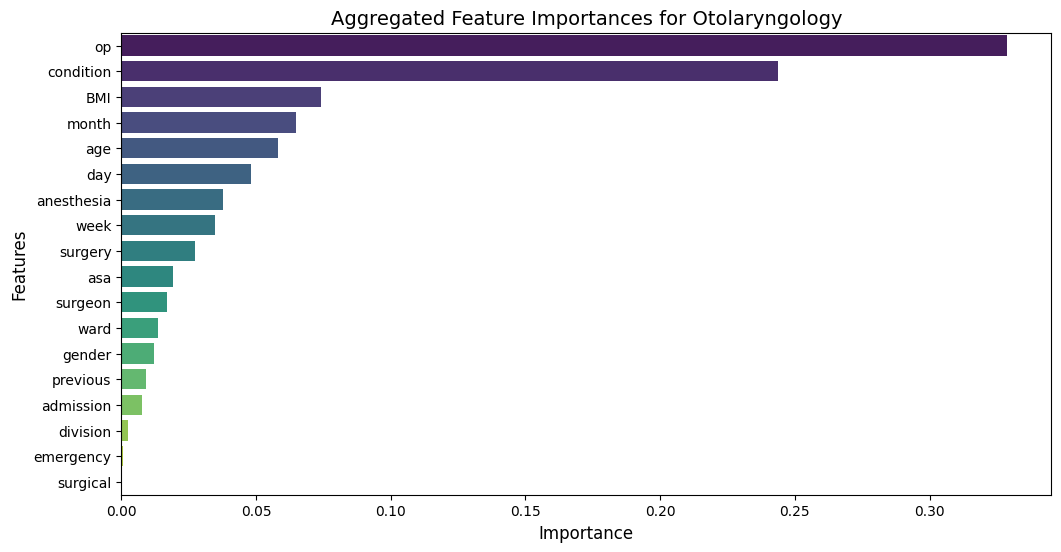

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


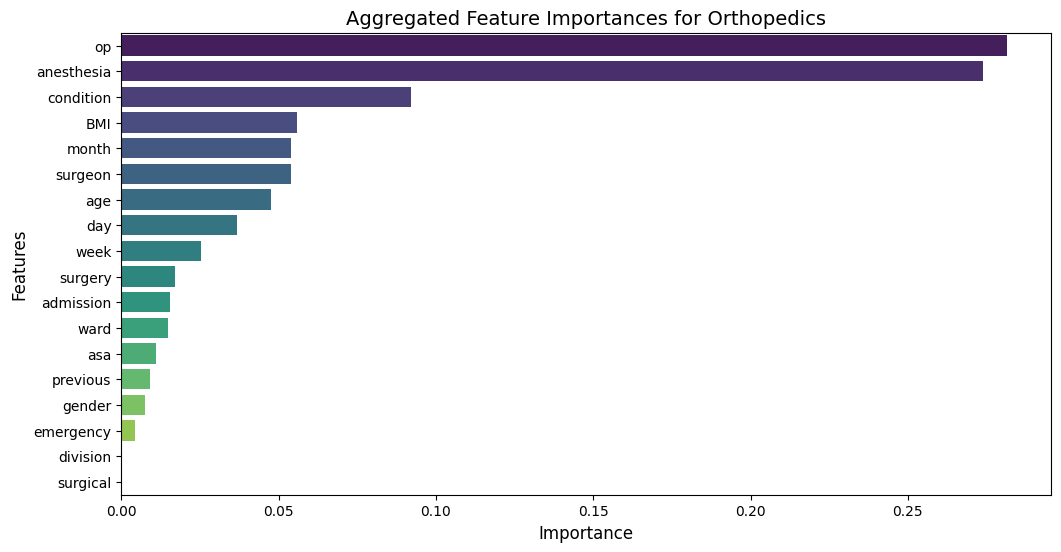

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


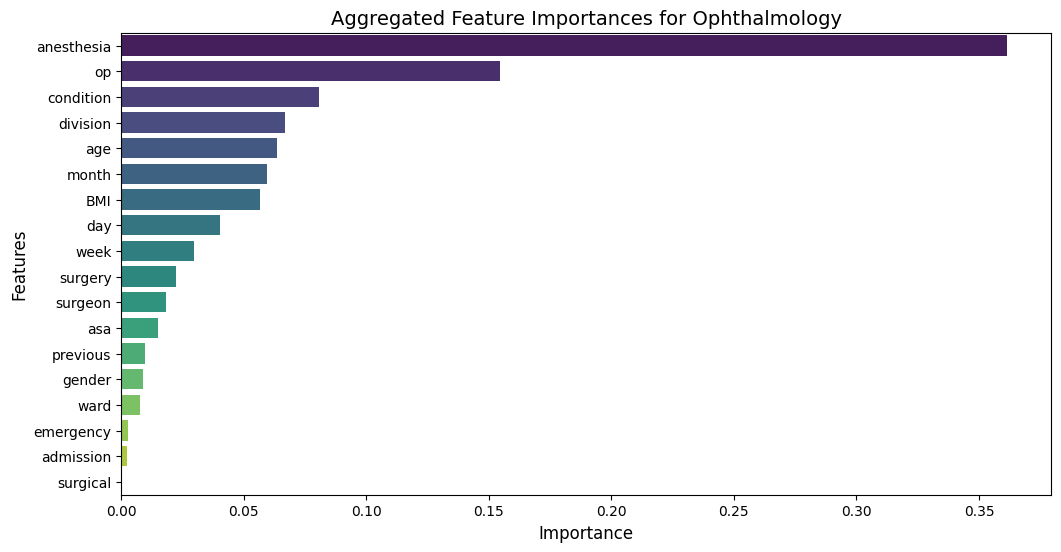

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


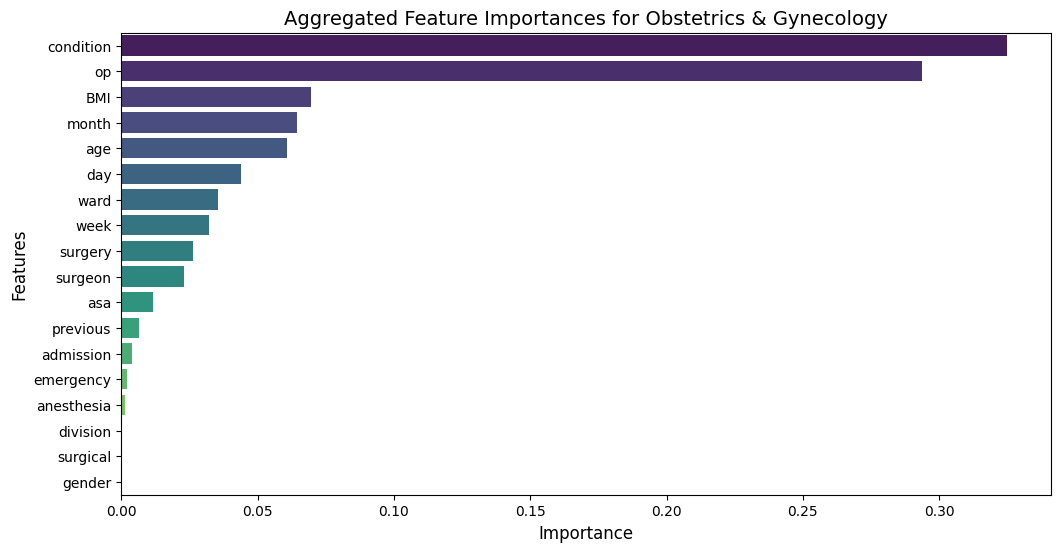

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


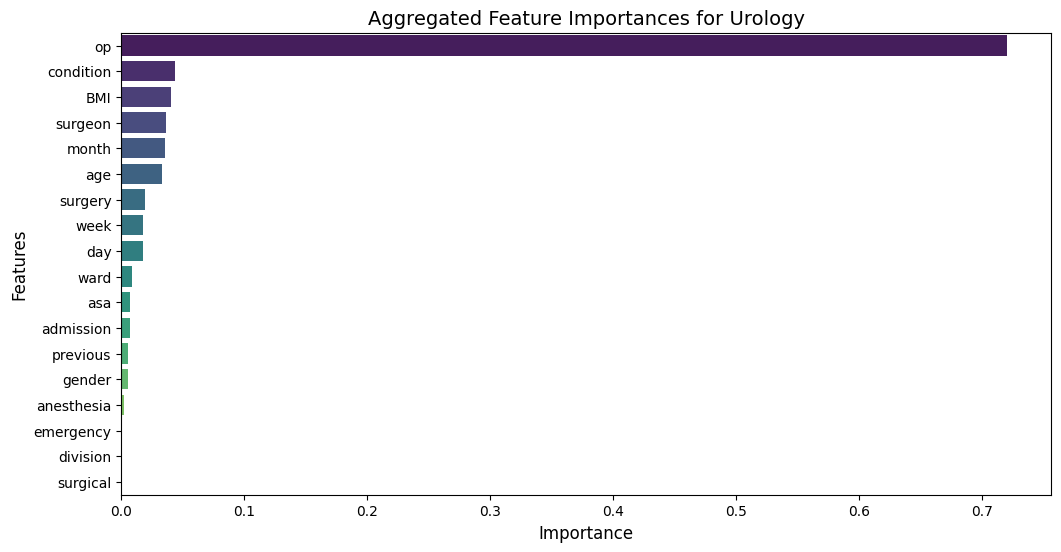

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


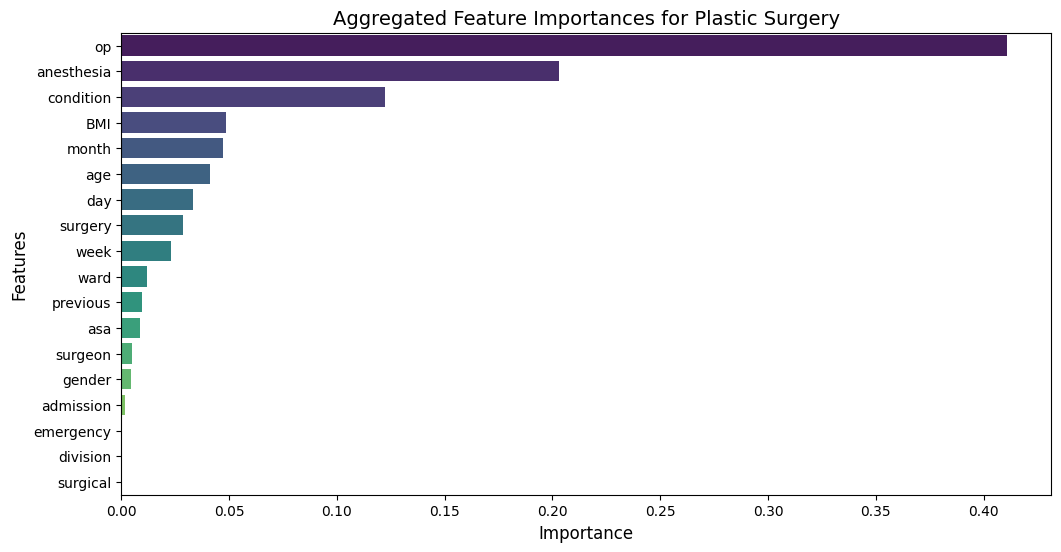

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


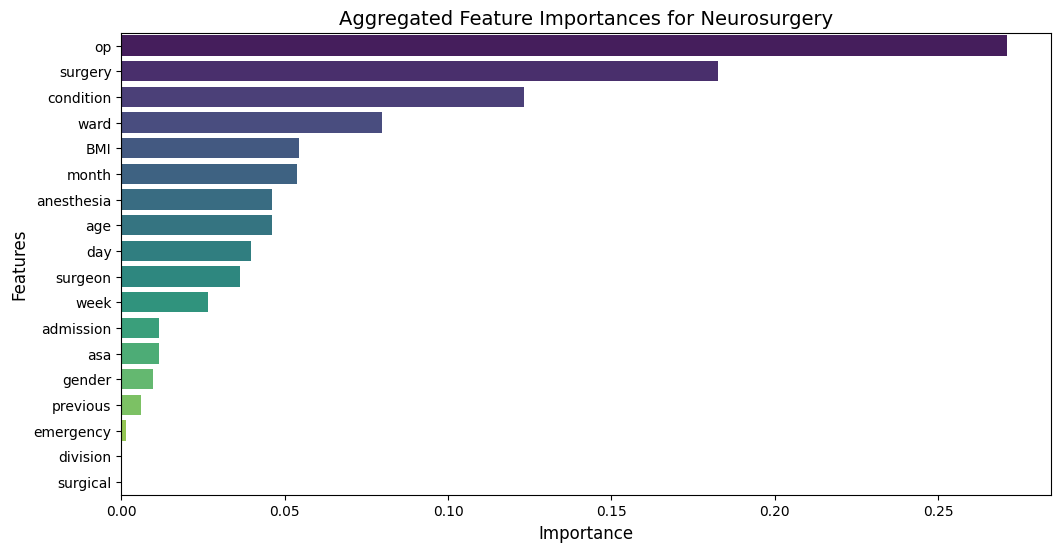

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


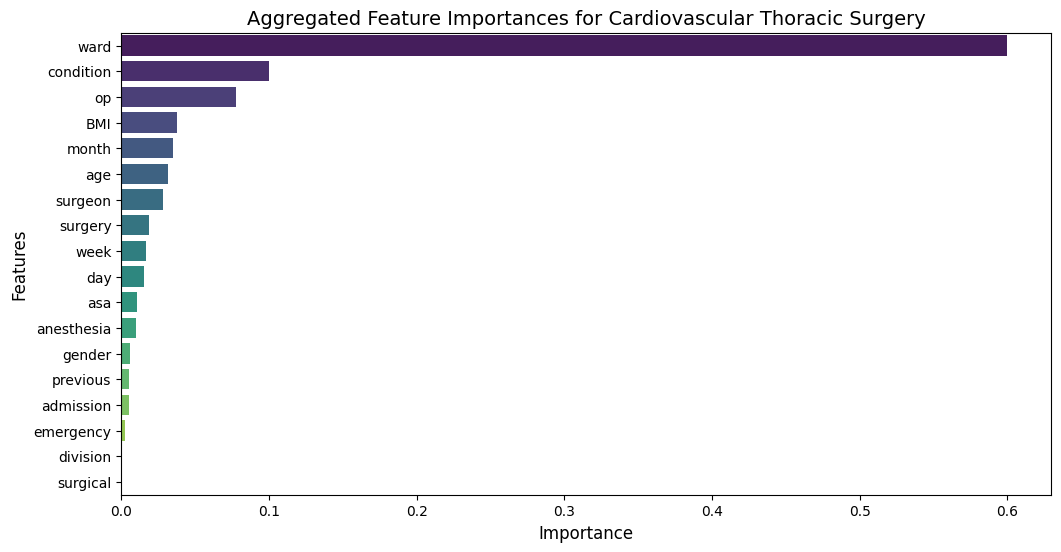

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


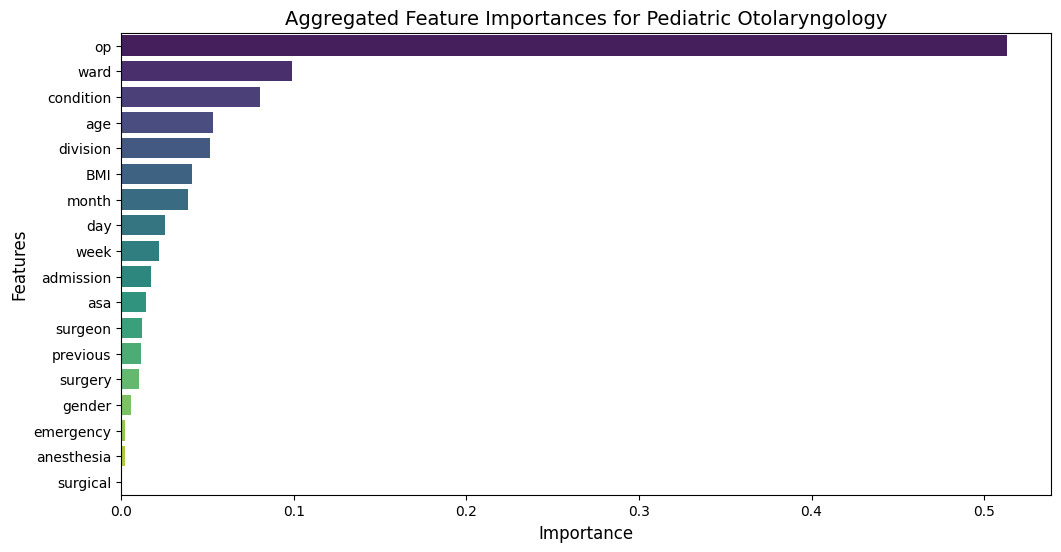

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


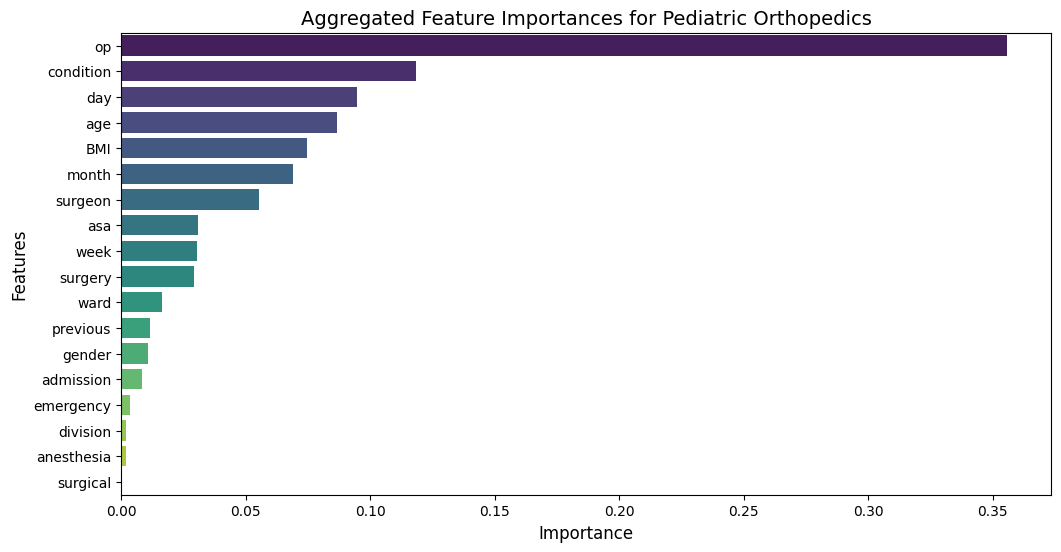

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


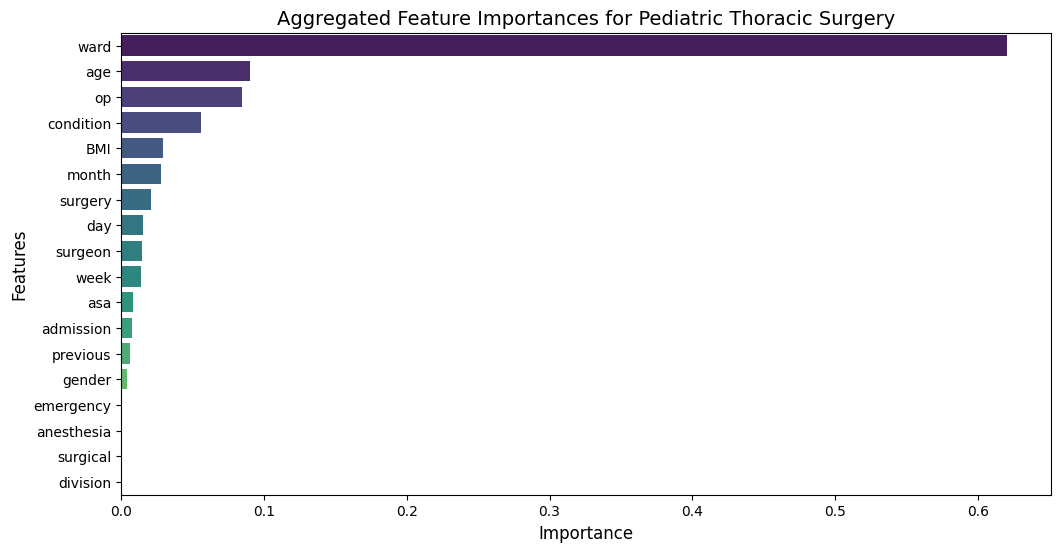

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


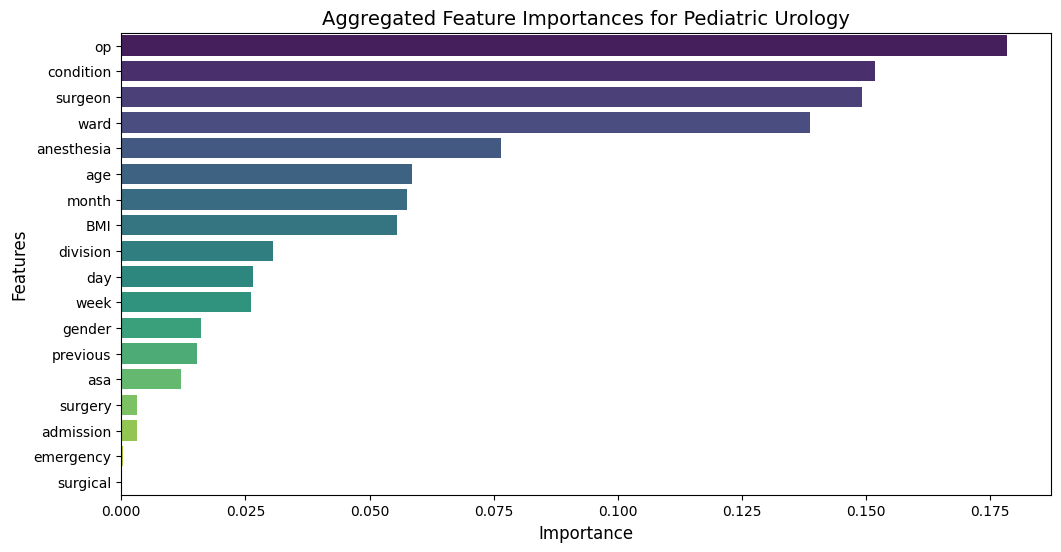

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


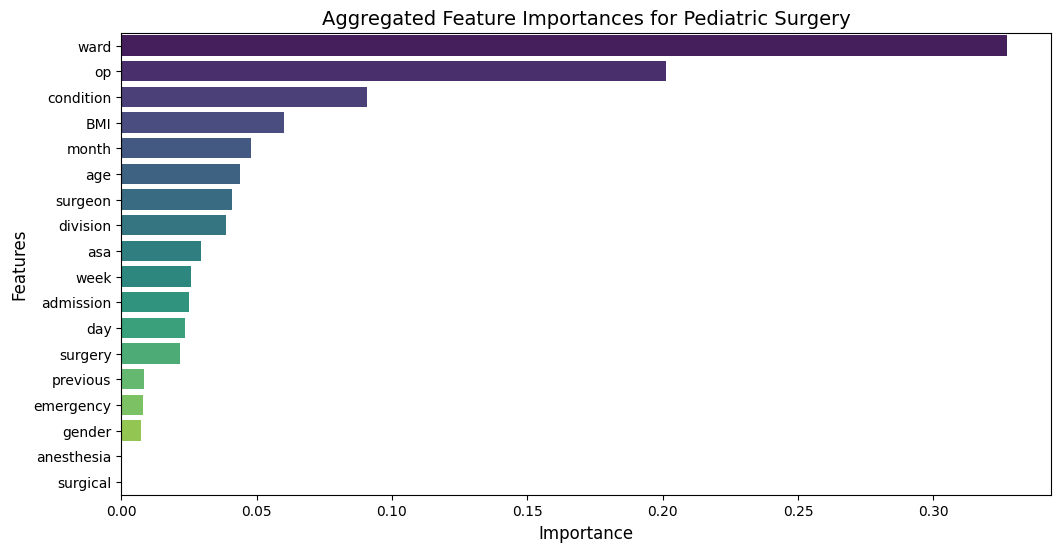

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


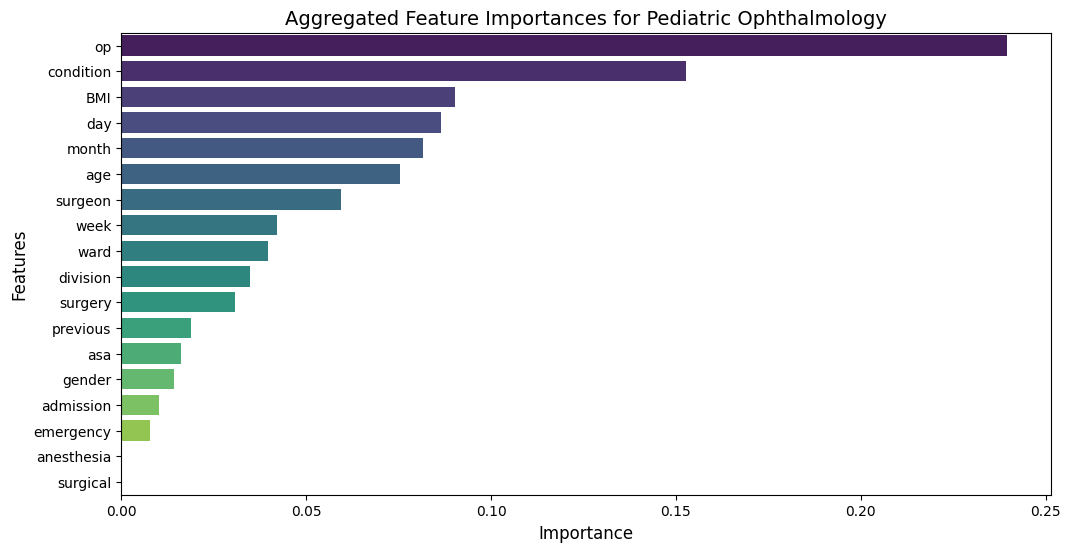

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


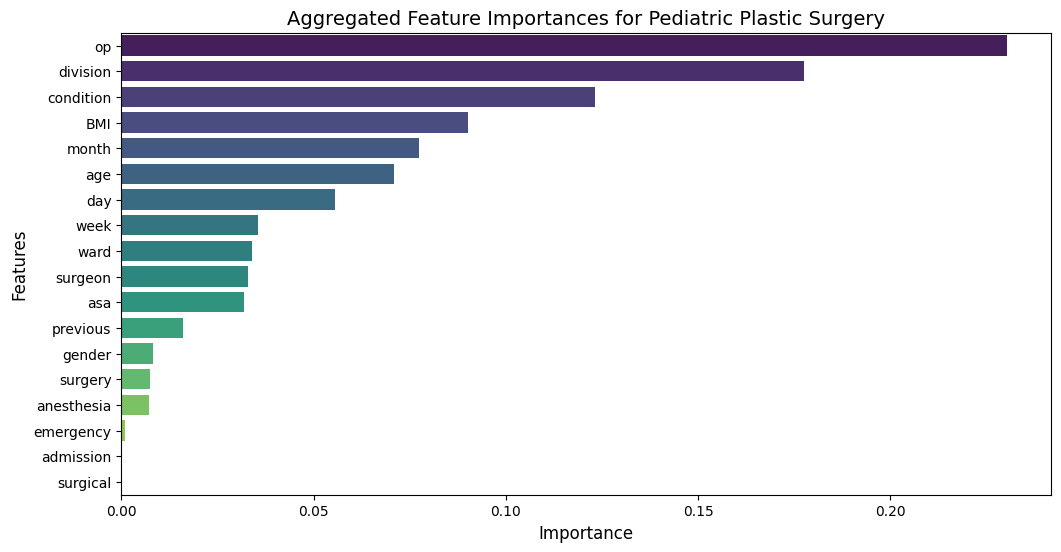

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_53312\1071490550.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


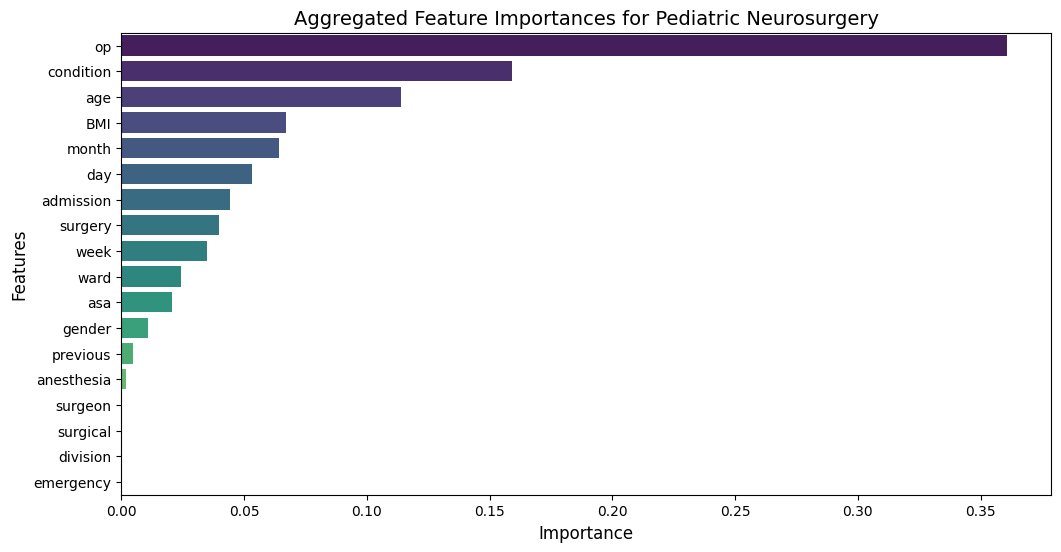

In [23]:
import seaborn as sns

for dept, model in models.items():
    # Get feature importances
    importances = model.feature_importances_

    # Aggregate importances for one-hot encoded features
    aggregated_importances = {}
    for i, col in enumerate(X_train_dept.columns):
        original_feature = col.split('_')[0]  # 원래 피처 이름 추출
        if original_feature not in aggregated_importances:
            aggregated_importances[original_feature] = 0
        aggregated_importances[original_feature] += importances[i]

    # Sort the aggregated importances in descending order
    sorted_importances = sorted(aggregated_importances.items(), key=lambda x: x[1], reverse=True)

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")
    plt.title(f"Aggregated Feature Importances for {dept}", fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.show()
